<a href="https://colab.research.google.com/github/ddkxip/xlstm-predictions/blob/main/notebooks/sp500_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Movement Prediction Using Wavelet-Based xLSTM-TS Model

**Notebook 1**: S&P 500 - Daily Close Prices

---


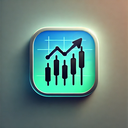

**Note**: Run with T4 GPU in Google Colab! (CUDA is required)

## Constants

**Dataset**: S&P 500 (US)

https://finance.yahoo.com/quote/%5EGSPC/

In [1]:
# Ticker (check in Yahoo Finance) and custom stock name
TICKER = '^GSPC' # S&P 500 index
STOCK = 'S&P 500'

# Date range (YYYY-MM-DD) and frequency
START_DATE = '2000-01-01'
END_DATE = '2023-12-31'
FREQ = '1d' # daily frequency

FILE_NAME = 'sp500_daily' # custom file name

*   **Train**: 01/2000 - 12/2020
*   **Validation**: 01/2021 - 06/2022
*   **Test**: 07/2022 - 12/2023

In [2]:
# Train, validation, test split
TRAIN_END_DATE = '2018-01-01'
VAL_END_DATE = '2020-01-01'

## Requirements

In [3]:
repo_url = 'https://github.com/gonzalopezgil/xlstm-ts.git'

# Clone the repository
!git clone {repo_url}

Cloning into 'xlstm-ts'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 333 (delta 61), reused 61 (delta 57), pack-reused 252 (from 1)
Receiving objects: 100% (333/333), 14.35 MiB | 31.01 MiB/s, done.
Resolving deltas: 100% (179/179), done.


In [4]:
%cd xlstm-ts

/content/xlstm-ts


NOTE: It can take a few minutes to install all dependencies.

In [5]:
!pip install -r requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 63.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 3.7 MB/s eta 0:00:00
Reason for being yanked: The Windows wheels, under some conditions, caused segfaults in unrelated user code.  Due to this we deleted the 

In [6]:
# Add the src directory to the Python path
import sys
import os

# Get the path of the current working directory
current_dir = os.getcwd()

# Construct the path to the 'src' directory in the current folder
src_path = os.path.join(current_dir, 'src')

# Add the 'src' directory to the Python path
if src_path not in sys.path:
    sys.path.append(src_path)

In [7]:
from ml.utils.imports import *

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [8]:
from ml.data.download import download_data
from ml.utils.visualisation import plot_data

In [9]:
'''
# Read the CSV file and set the "Date" column as the index
file_path = os.path.join('data', 'datasets', FILE_NAME + '.csv')
df = pd.read_csv(file_path, header=0, index_col='Date')
# Convert the index to a datetime object
df.index = df.index.to_series().apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z"))
'''

'\n# Read the CSV file and set the "Date" column as the index\nfile_path = os.path.join(\'data\', \'datasets\', FILE_NAME + \'.csv\')\ndf = pd.read_csv(file_path, header=0, index_col=\'Date\')\n# Convert the index to a datetime object\ndf.index = df.index.to_series().apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z"))\n'

### Download data

- **Tiingo**: If the frequency is hourly and the starting date is more than 2 years before, the Tiingo API will be used. You need to enter the API key to proceed (the steps are explained above). Note that restrictive API limitations apply.

- **Yahoo Finance**: In all other cases, Yahoo Finance will be used. There's no need to enter an API key to download data from it, and there are no API restrictions with responsible usage.

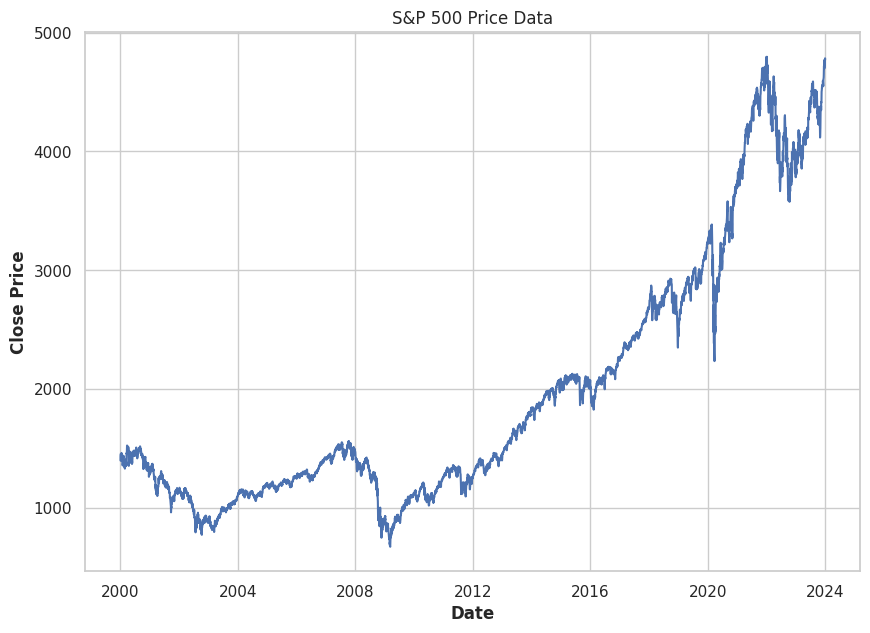

In [10]:
# Download the data
df = download_data(ticker=TICKER, start_date=START_DATE, end_date=END_DATE, freq=FREQ)

# Plot the raw data
plot_data(df, STOCK)

## Preprocessing

### Wavelet denoising

Reference:
https://doi.org/10.1002/for.3071 (the idea of the wavelet denoising and some parameters are taken from this paper)

In [19]:
from ml.data.preprocessing import wavelet_denoising, plot_wavelet_denoising

Signal-to-Noise Ratio (SNR): 46.28 dB


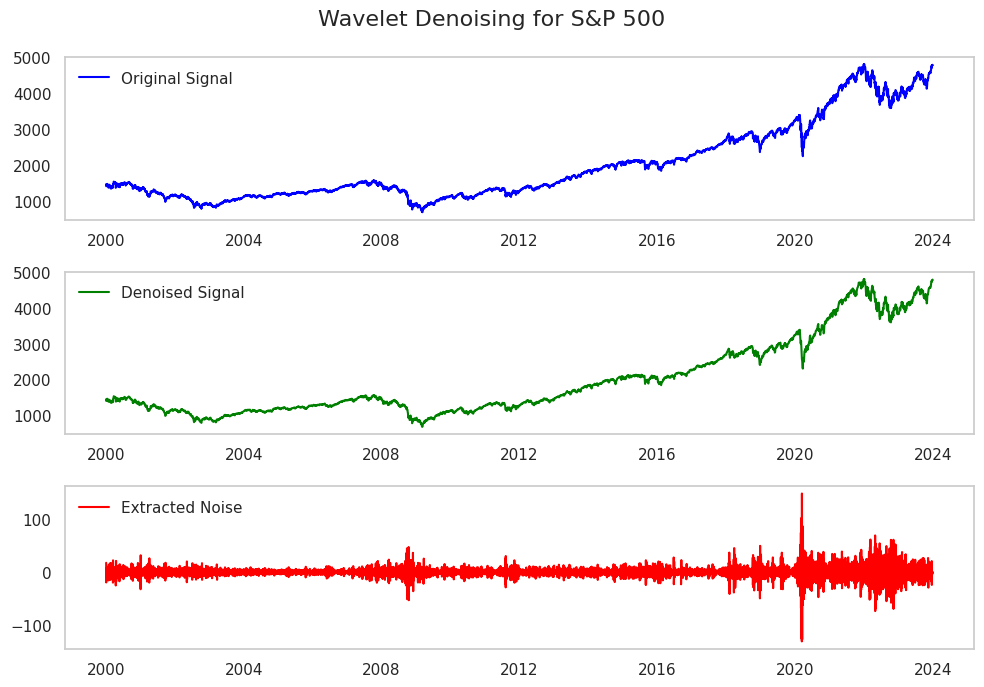

In [20]:
# Apply denoising
df['Close_denoised'] = wavelet_denoising(df['Close'])
df['Noise'] = df['Close'] - df['Close_denoised']

plot_wavelet_denoising(df, STOCK)

### Process dates

In [21]:
from ml.data.preprocessing import process_dates

In [22]:
# Convert the Date column to time zone-naive datetime
df = process_dates(df)

### Model-specific preprocessing

#### For darts library models

##### Convert to darts TimeSeries

**Darts Library**:

- Paper: https://www.jmlr.org/papers/v23/21-1177.html
- Documentation: https://unit8co.github.io/darts/README.html#
- Repository: https://github.com/unit8co/darts

In [23]:
from ml.models.darts.preprocessing import convert_to_ts_daily

In [24]:
series, series_denoised = convert_to_ts_daily(df)
series_denoised

<TimeSeries (DataArray) (Date: 6037, component: 1, sample: 1)> Size: 48kB
array([[[1437.6764069 ]],

       [[1419.02923629]],

       [[1395.54938238]],

       ...,

       [[4781.45492258]],

       [[4782.76373207]],

       [[4771.75571991]]])
Coordinates:
  * Date       (Date) datetime64[ns] 48kB 2000-01-03 2000-01-04 ... 2023-12-29
  * component  (component) <U1 4B '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

##### Train, Validation and Test split

In [25]:
from ml.models.darts.preprocessing import split_train_val_test_darts

In [26]:
# Transform the string dates into datetime objects
TRAIN_END_DATE = datetime.datetime.strptime(TRAIN_END_DATE, '%Y-%m-%d')
VAL_END_DATE = datetime.datetime.strptime(VAL_END_DATE, '%Y-%m-%d')

In [27]:
train, val, test = split_train_val_test_darts(series, TRAIN_END_DATE, VAL_END_DATE)
train_denoised, val_denoised, test_denoised = split_train_val_test_darts(series_denoised, TRAIN_END_DATE, VAL_END_DATE)

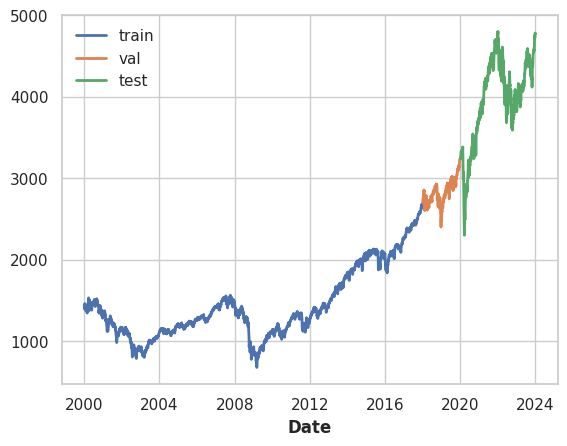

In [28]:
train_denoised.plot(label="train");
val_denoised.plot(label="val");
test_denoised.plot(label="test");

##### Normalise data

In [29]:
from ml.models.darts.preprocessing import normalise_split_data_darts

In [30]:
train, val, test, scaler_darts = normalise_split_data_darts(train, val, test)
train_denoised, val_denoised, test_denoised, scaler_darts_denoised = normalise_split_data_darts(train_denoised, val_denoised, test_denoised)

#### For the proposed model

##### Normalise data

In [31]:
from ml.models.xlstm_ts.preprocessing import normalise_data_xlstm

In [32]:
close_scaled, scaler = normalise_data_xlstm(df['Close'].values)

In [33]:
close_scaled_denoised, scaler_denoised = normalise_data_xlstm(df['Close_denoised'].values)

##### Create sequences

In [34]:
from ml.models.xlstm_ts.preprocessing import create_sequences

In [35]:
X, y, dates = create_sequences(close_scaled, df.index)

In [36]:
X_denoised, y_denoised, _ = create_sequences(close_scaled_denoised, df.index)

##### Train, Validation and Test split

In [37]:
from ml.models.xlstm_ts.preprocessing import split_train_val_test_xlstm

train X shape: torch.Size([4378, 150, 1])
train y shape: torch.Size([4378, 1])
val X shape: torch.Size([503, 150, 1])
val y shape: torch.Size([503, 1])
test X shape: torch.Size([1006, 150, 1])
test y shape: torch.Size([1006, 1])


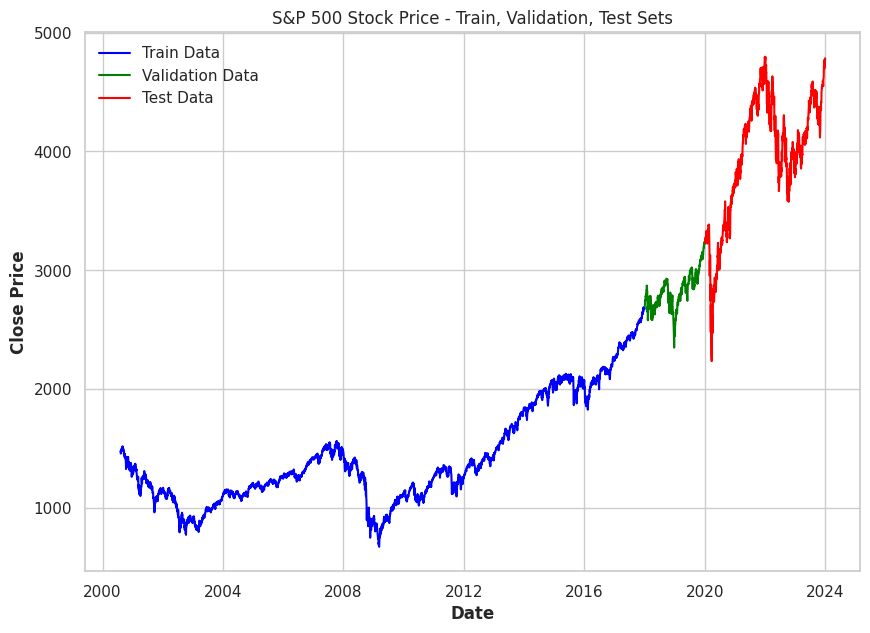

In [38]:
train_X, train_y, train_dates, val_X, val_y, val_dates, test_X, test_y, test_dates = split_train_val_test_xlstm(X, y, dates, TRAIN_END_DATE, VAL_END_DATE, scaler, STOCK)

train X shape: torch.Size([4378, 150, 1])
train y shape: torch.Size([4378, 1])
val X shape: torch.Size([503, 150, 1])
val y shape: torch.Size([503, 1])
test X shape: torch.Size([1006, 150, 1])
test y shape: torch.Size([1006, 1])


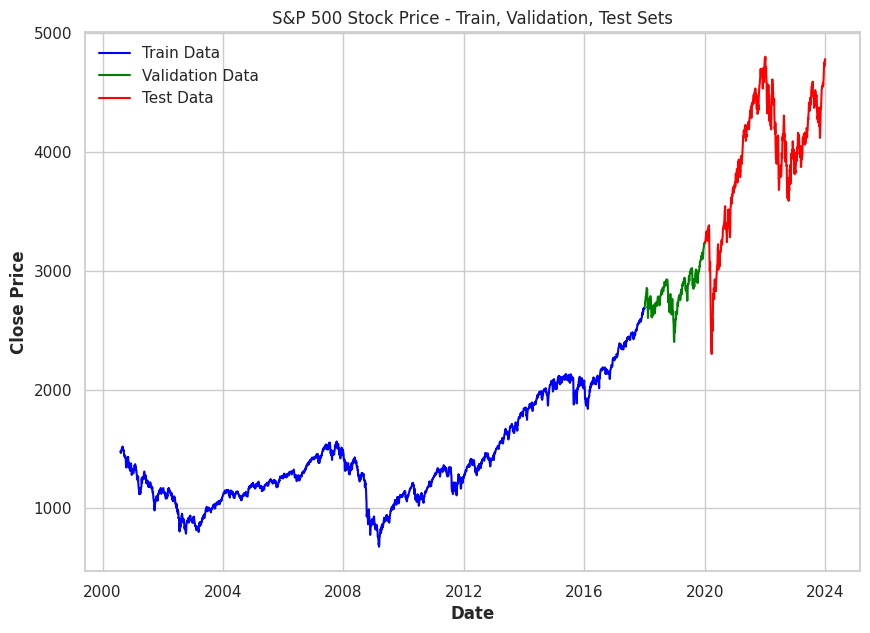

In [39]:
train_X_denoised, train_y_denoised, _, val_X_denoised, val_y_denoised, _, test_X_denoised, test_y_denoised, _ = split_train_val_test_xlstm(X_denoised, y_denoised, dates, TRAIN_END_DATE, VAL_END_DATE, scaler_denoised, STOCK)

## Models

In [40]:
from ml.models.shared.directional_prediction import *
from ml.models.shared.metrics import *
from ml.models.shared.visualisation import *
from ml.models.darts.darts_models import *
from ml.models.darts.training import *

In [41]:
metrics_accumulator = {}
metrics_accumulator_denoised = {}

### TCN

**References**:

- Paper (2018): https://doi.org/10.48550/arXiv.1803.01271
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tcn_model.py
- Darts documentation: https://unit8co.github.io/darts/examples/05-TCN-examples.html

**Not denoised**

Price Prediction Metrics:

TCN (Original) | MAE: 35.75
TCN (Original) | MSE: 2251.25
TCN (Original) | RMSE: 47.45
TCN (Original) | RMSSE: 1.06
TCN (Original) | MAPE: 0.89%
TCN (Original) | MASE: 1.07
TCN (Original) | R2: 0.99


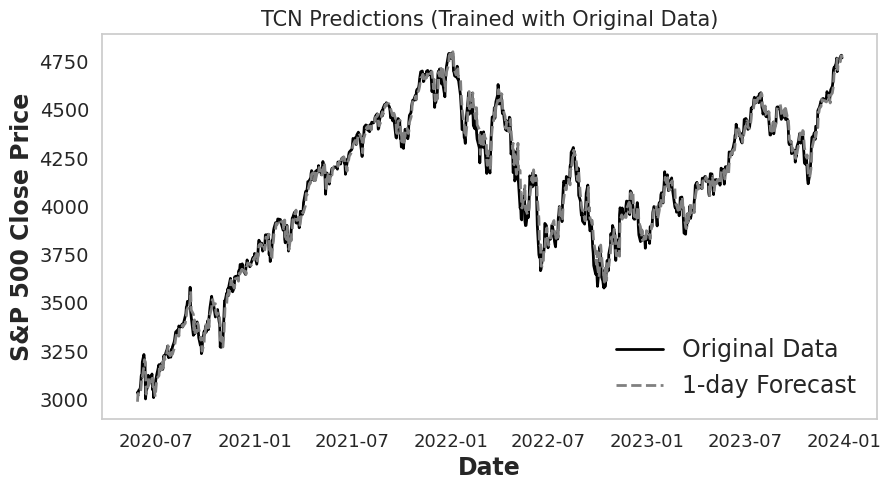

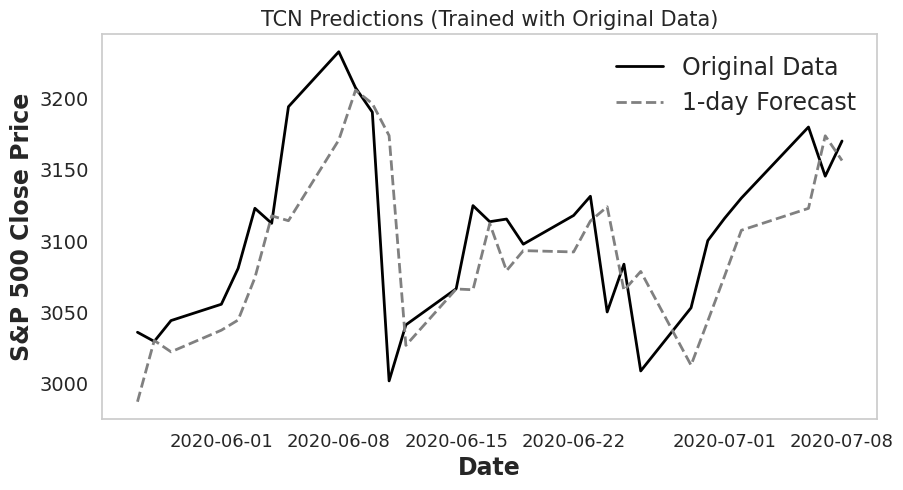


Directional Movement Metrics:

TCN (Original) | Train Accuracy: 47.91%
TCN (Original) | Validation Accuracy: 50.75%
TCN (Original) | Test Accuracy: 48.51%
TCN (Original) | Recall: 52.61%
TCN (Original) | Precision (Rise): 51.32%
TCN (Original) | Precision (Fall): 45.17%
TCN (Original) | F1 Score: 51.96%


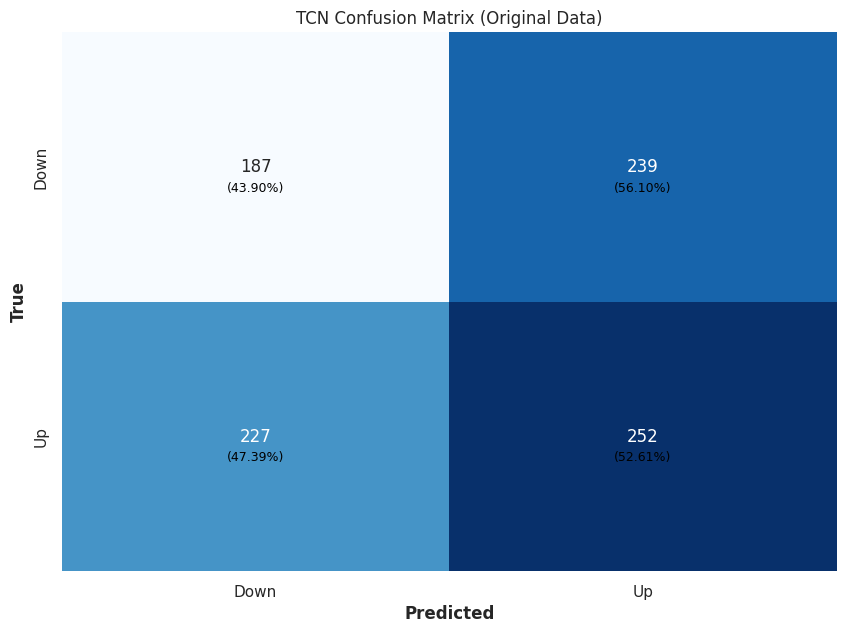

In [42]:
model = get_model_tcn()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

**Denoised**

Price Prediction Metrics:

TCN (Denoised) | MAE: 30.61
TCN (Denoised) | MSE: 1622.53
TCN (Denoised) | RMSE: 40.28
TCN (Denoised) | RMSSE: 0.90
TCN (Denoised) | MAPE: 0.76%
TCN (Denoised) | MASE: 0.91
TCN (Denoised) | R2: 0.99


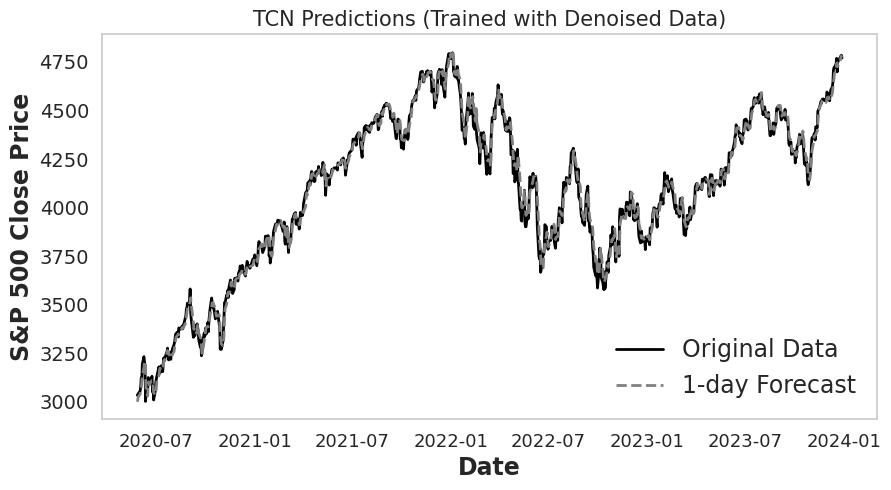

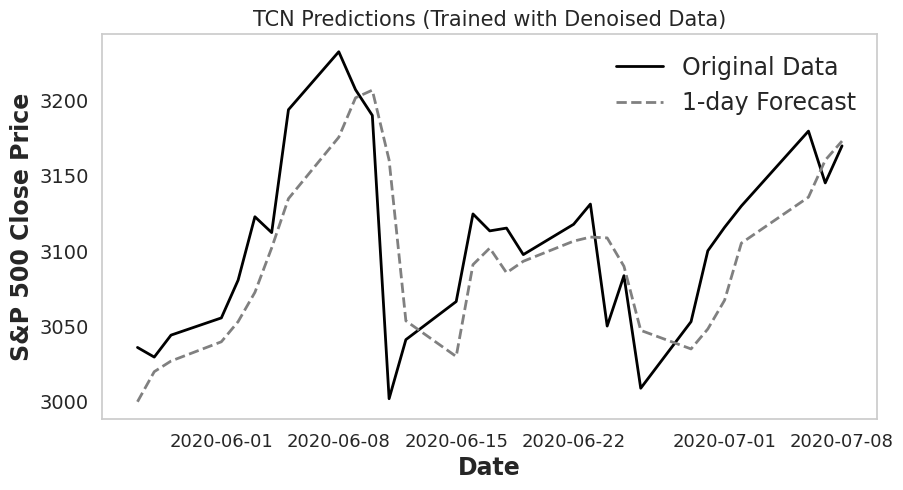


Directional Movement Metrics:

TCN (Denoised) | Train Accuracy: 64.20%
TCN (Denoised) | Validation Accuracy: 63.18%
TCN (Denoised) | Test Accuracy: 63.43%
TCN (Denoised) | Recall: 70.77%
TCN (Denoised) | Precision (Rise): 63.96%
TCN (Denoised) | Precision (Fall): 62.67%
TCN (Denoised) | F1 Score: 67.20%


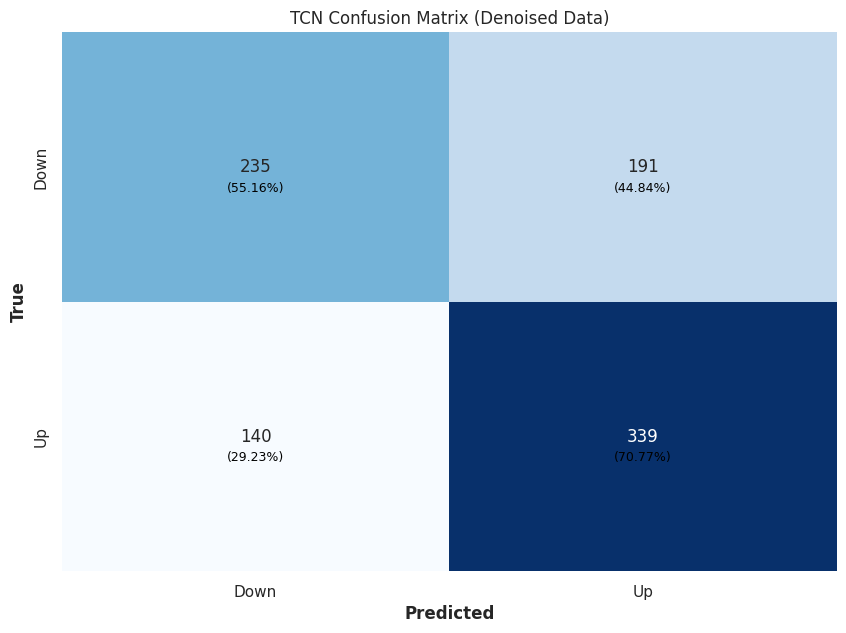

In [43]:
model = get_model_tcn()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### DeepTCN

**References**:

- Paper (2020): https://doi.org/10.48550/arXiv.1906.04397
- Code (same as TCN): https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tcn_model.py
- Darts documentation: https://unit8co.github.io/darts/examples/09-DeepTCN-examples.html

**Not denoised**

Price Prediction Metrics:

DeepTCN (Original) | MAE: 39.27
DeepTCN (Original) | MSE: 2389.67
DeepTCN (Original) | RMSE: 48.88
DeepTCN (Original) | RMSSE: 1.10
DeepTCN (Original) | MAPE: 0.98%
DeepTCN (Original) | MASE: 1.17
DeepTCN (Original) | R2: 0.99


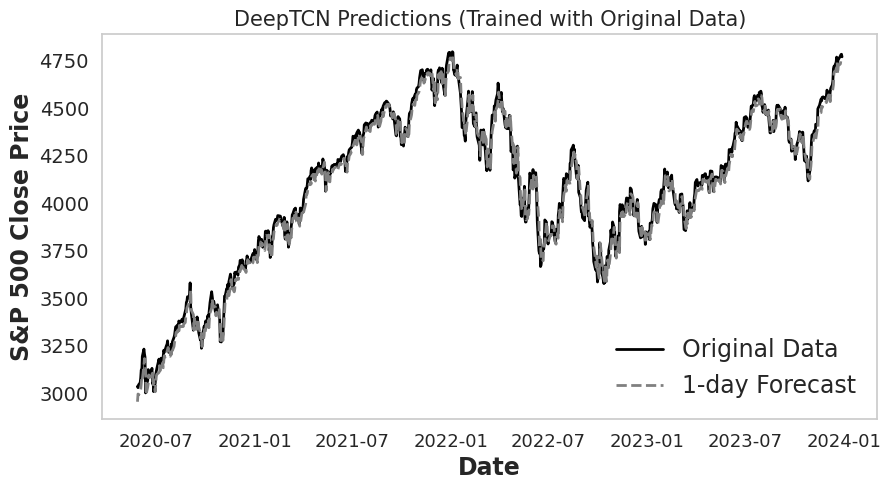

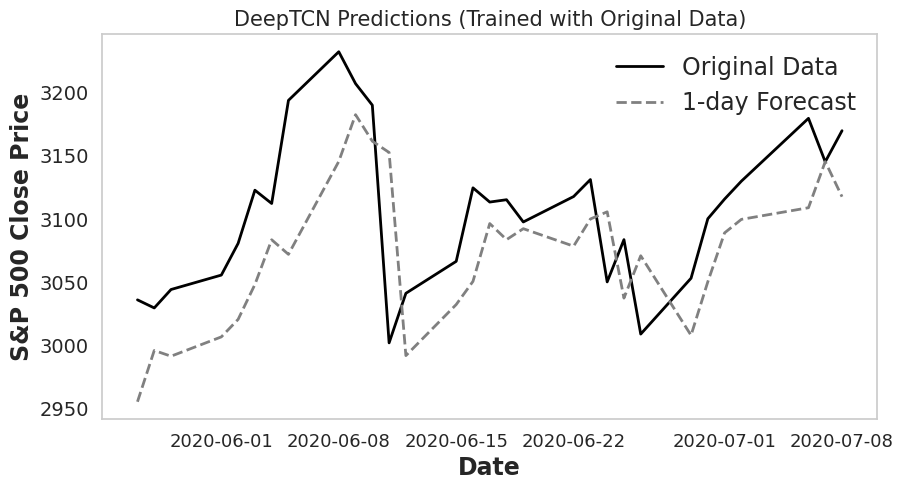


Directional Movement Metrics:

DeepTCN (Original) | Train Accuracy: 47.12%
DeepTCN (Original) | Validation Accuracy: 52.24%
DeepTCN (Original) | Test Accuracy: 47.96%
DeepTCN (Original) | Recall: 51.77%
DeepTCN (Original) | Precision (Rise): 50.82%
DeepTCN (Original) | Precision (Fall): 44.60%
DeepTCN (Original) | F1 Score: 51.29%


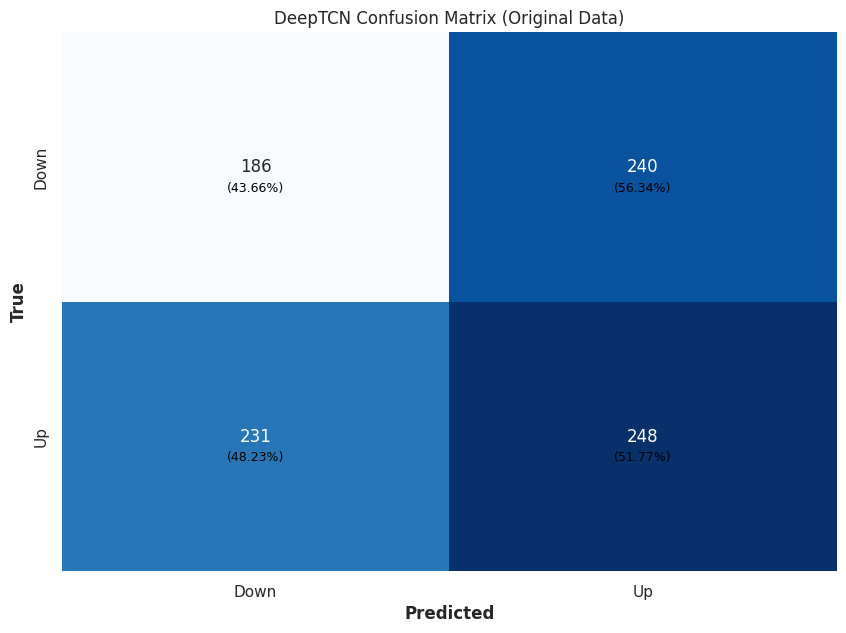

In [44]:
model = get_model_deeptcn()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

**Denoised**

Price Prediction Metrics:

DeepTCN (Denoised) | MAE: 32.46
DeepTCN (Denoised) | MSE: 1638.08
DeepTCN (Denoised) | RMSE: 40.47
DeepTCN (Denoised) | RMSSE: 0.91
DeepTCN (Denoised) | MAPE: 0.81%
DeepTCN (Denoised) | MASE: 0.97
DeepTCN (Denoised) | R2: 0.99


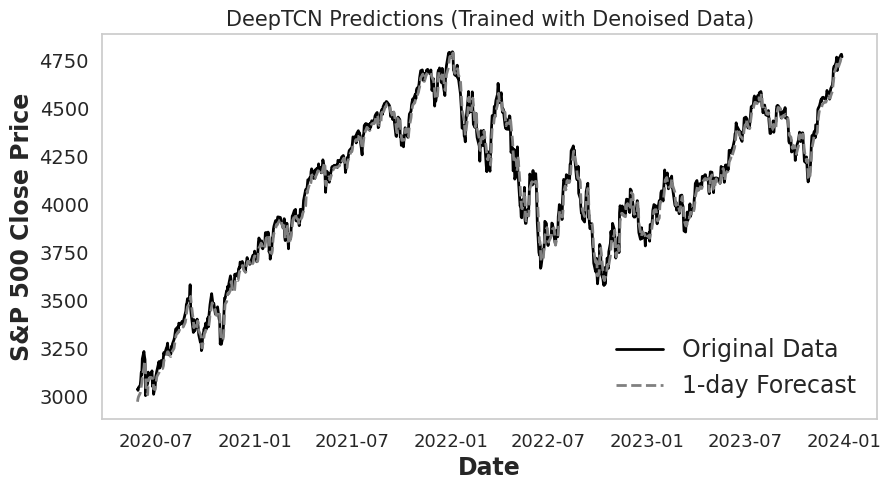

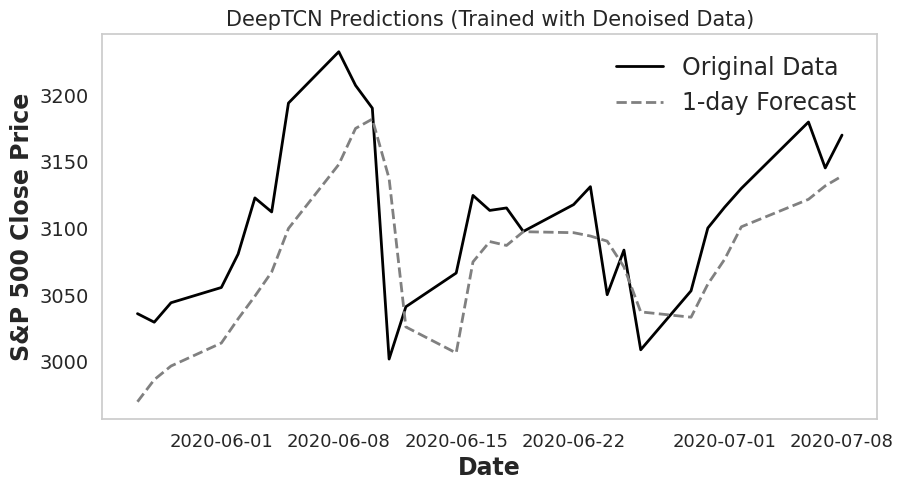


Directional Movement Metrics:

DeepTCN (Denoised) | Train Accuracy: 64.72%
DeepTCN (Denoised) | Validation Accuracy: 65.92%
DeepTCN (Denoised) | Test Accuracy: 64.64%
DeepTCN (Denoised) | Recall: 72.23%
DeepTCN (Denoised) | Precision (Rise): 64.92%
DeepTCN (Denoised) | Precision (Fall): 64.25%
DeepTCN (Denoised) | F1 Score: 68.38%


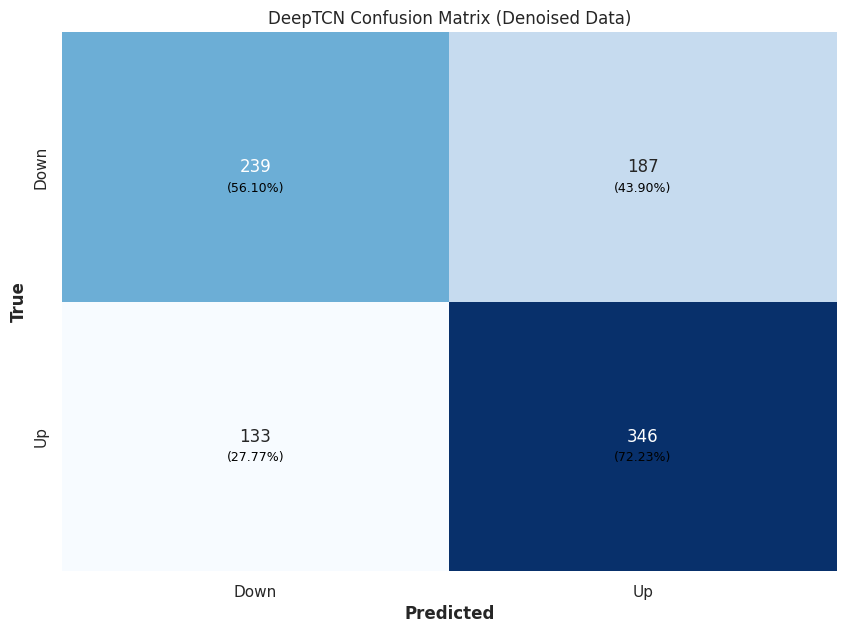

In [45]:
model = get_model_deeptcn()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### N-BEATS

**References**:
- Paper (2020): https://doi.org/10.48550/arXiv.1905.10437
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/nbeats.py
- Darts documentation: https://unit8co.github.io/darts/examples/07-NBEATS-examples.html

**Not denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-BEATS (Original) | MAE: 48.06
N-BEATS (Original) | MSE: 4116.32
N-BEATS (Original) | RMSE: 64.16
N-BEATS (Original) | RMSSE: 1.44
N-BEATS (Original) | MAPE: 1.21%
N-BEATS (Original) | MASE: 1.44
N-BEATS (Original) | R2: 0.98


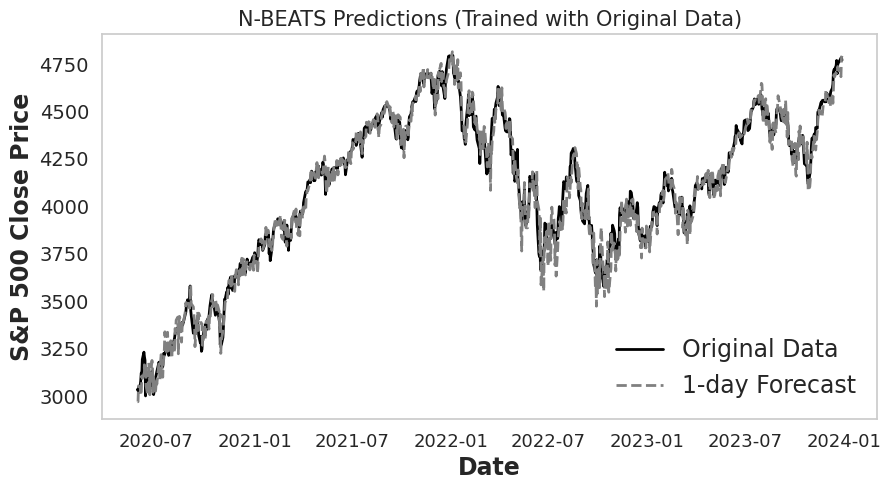

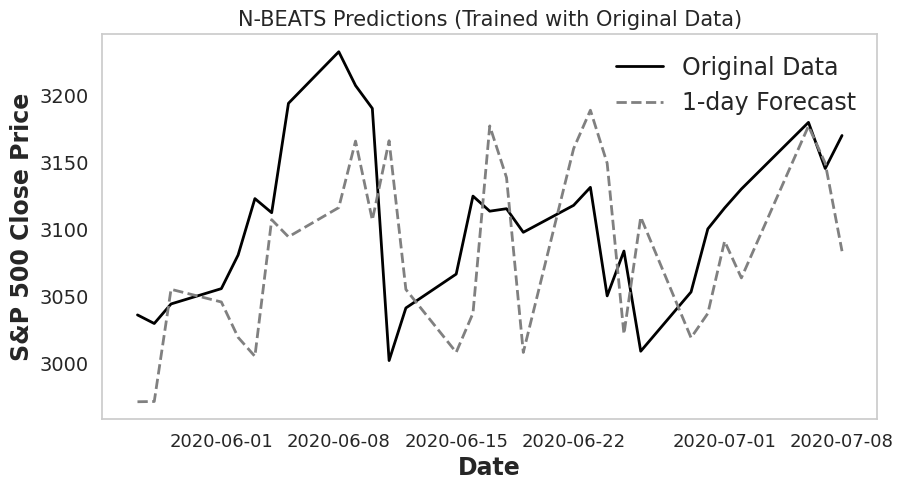


Directional Movement Metrics:

N-BEATS (Original) | Train Accuracy: 53.72%
N-BEATS (Original) | Validation Accuracy: 50.25%
N-BEATS (Original) | Test Accuracy: 52.15%
N-BEATS (Original) | Recall: 53.24%
N-BEATS (Original) | Precision (Rise): 54.96%
N-BEATS (Original) | Precision (Fall): 49.21%
N-BEATS (Original) | F1 Score: 54.08%


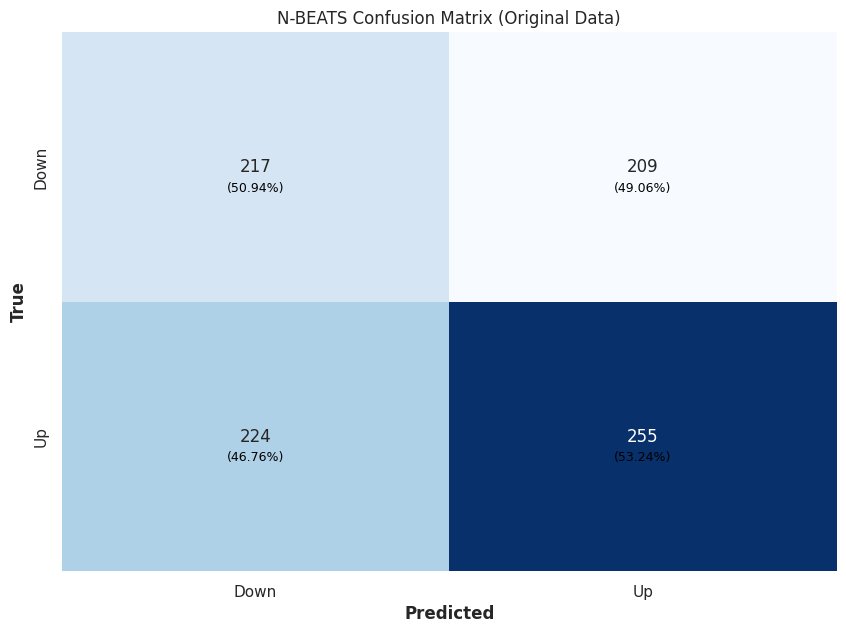

In [46]:
model = get_model_nbeats()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

**Denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-BEATS (Denoised) | MAE: 35.25
N-BEATS (Denoised) | MSE: 2277.16
N-BEATS (Denoised) | RMSE: 47.72
N-BEATS (Denoised) | RMSSE: 1.07
N-BEATS (Denoised) | MAPE: 0.88%
N-BEATS (Denoised) | MASE: 1.05
N-BEATS (Denoised) | R2: 0.99


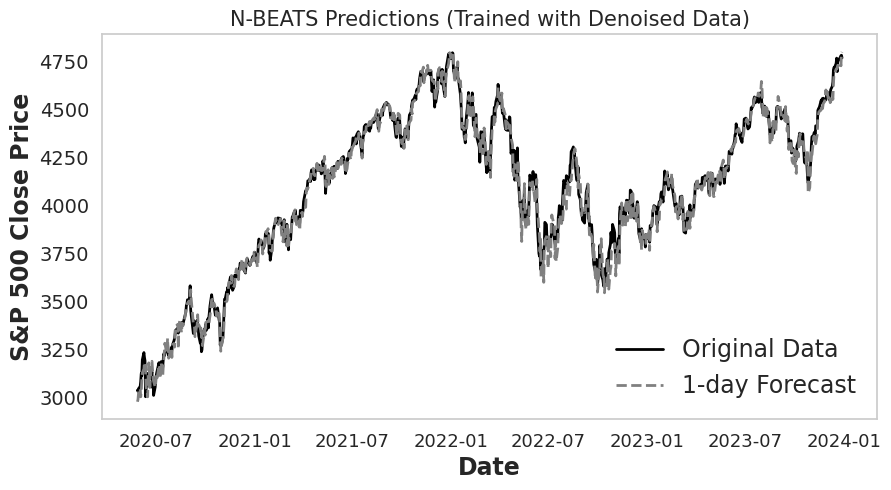

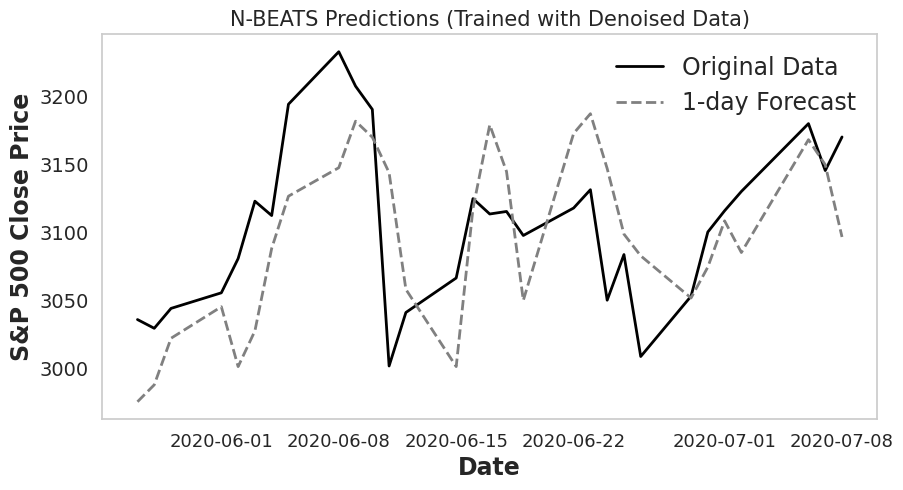


Directional Movement Metrics:

N-BEATS (Denoised) | Train Accuracy: 61.89%
N-BEATS (Denoised) | Validation Accuracy: 59.95%
N-BEATS (Denoised) | Test Accuracy: 61.44%
N-BEATS (Denoised) | Recall: 65.14%
N-BEATS (Denoised) | Precision (Rise): 63.16%
N-BEATS (Denoised) | Precision (Fall): 59.37%
N-BEATS (Denoised) | F1 Score: 64.13%


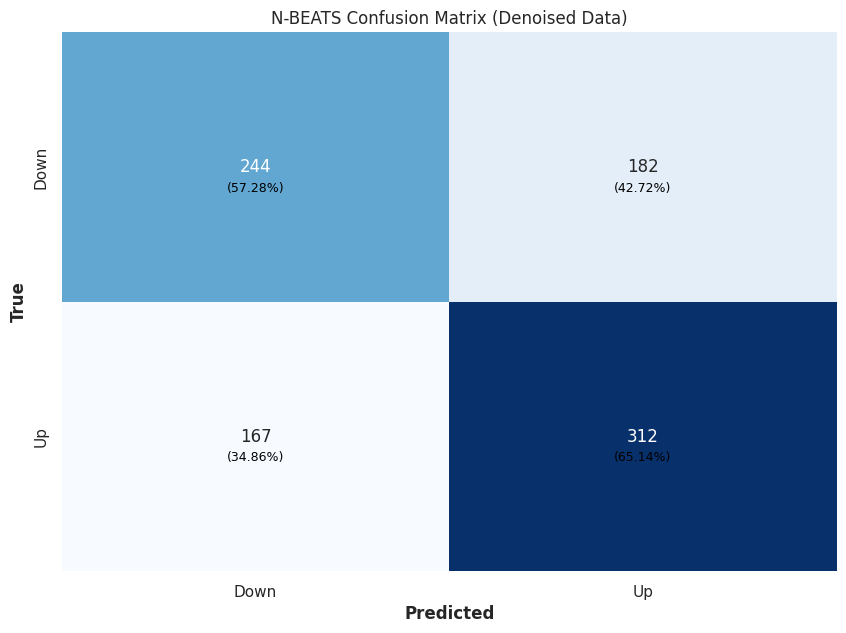

In [47]:
model = get_model_nbeats()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### TFT

Temporal Fusion Transformer Model

**References**:

- Paper (2021): https://doi.org/10.1016/j.ijforecast.2021.03.012
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tft_model.py
- Darts documentation: https://unit8co.github.io/darts/examples/13-TFT-examples.html

**Not denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TFT (Original) | MAE: 67.78
TFT (Original) | MSE: 9255.08
TFT (Original) | RMSE: 96.20
TFT (Original) | RMSSE: 2.16
TFT (Original) | MAPE: 1.71%
TFT (Original) | MASE: 2.02
TFT (Original) | R2: 0.95


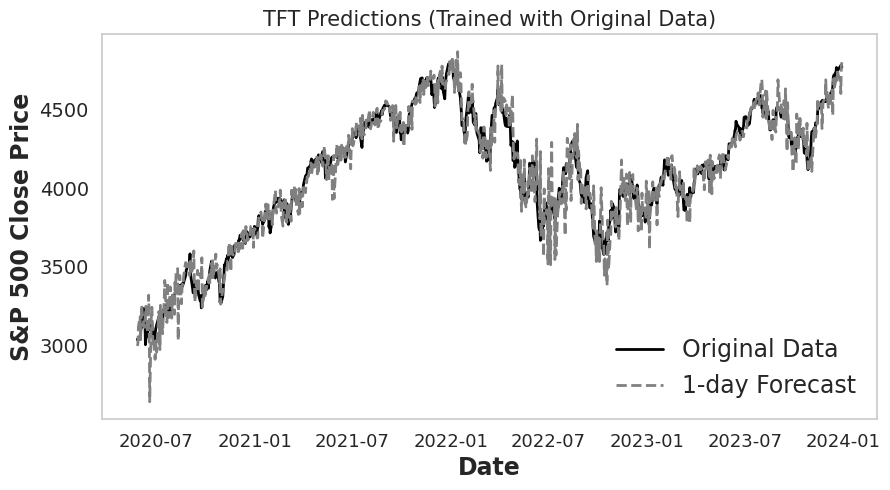

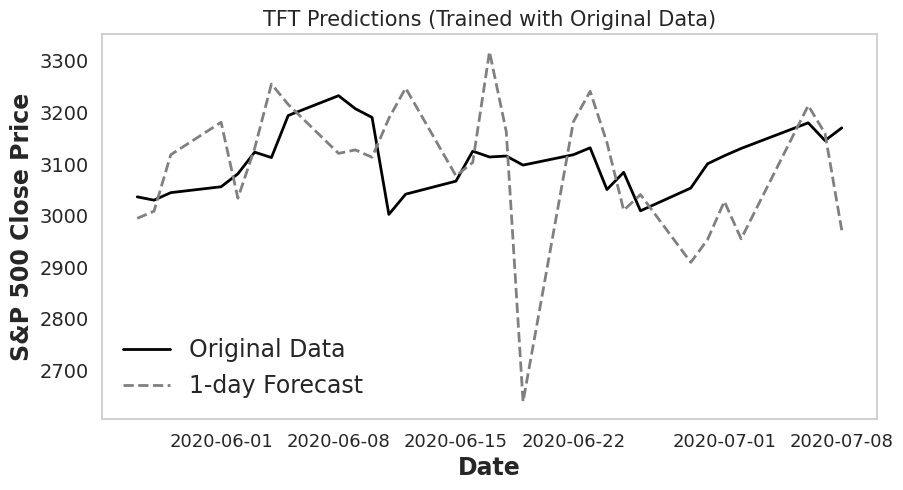


Directional Movement Metrics:

TFT (Original) | Train Accuracy: 48.57%
TFT (Original) | Validation Accuracy: 49.00%
TFT (Original) | Test Accuracy: 51.49%
TFT (Original) | Recall: 53.24%
TFT (Original) | Precision (Rise): 54.26%
TFT (Original) | Precision (Fall): 48.51%
TFT (Original) | F1 Score: 53.74%


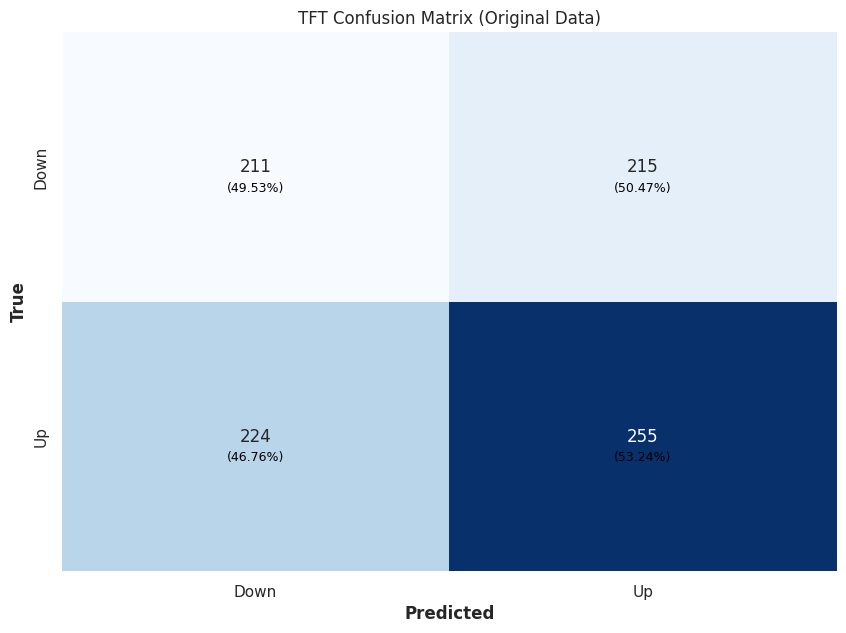

In [48]:
model = get_model_tft()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

**Denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TFT (Denoised) | MAE: 62.68
TFT (Denoised) | MSE: 8001.78
TFT (Denoised) | RMSE: 89.45
TFT (Denoised) | RMSSE: 2.00
TFT (Denoised) | MAPE: 1.58%
TFT (Denoised) | MASE: 1.87
TFT (Denoised) | R2: 0.95


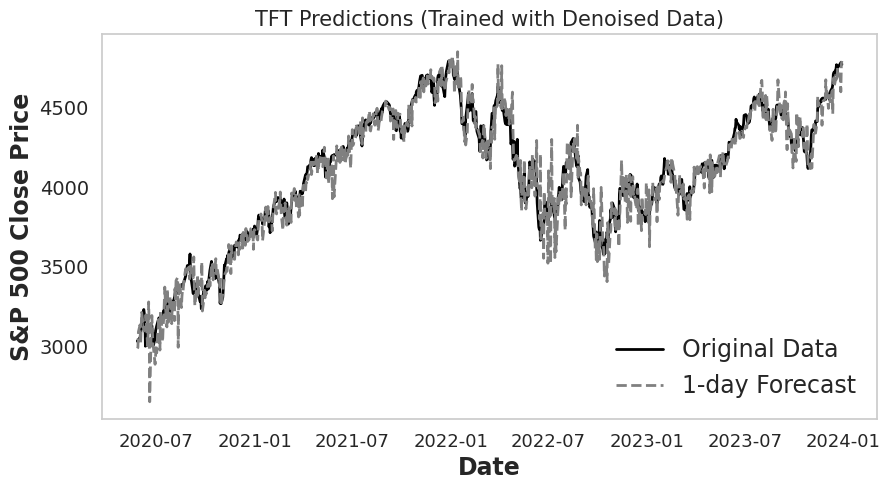

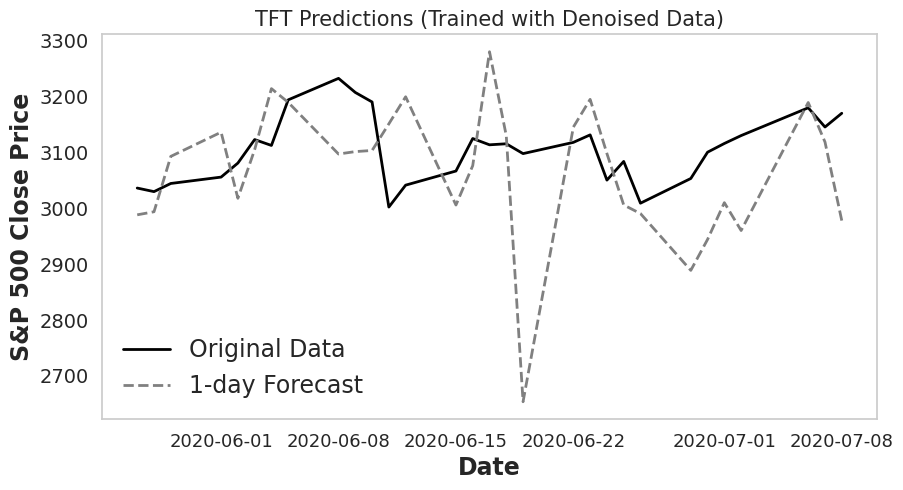


Directional Movement Metrics:

TFT (Denoised) | Train Accuracy: 51.52%
TFT (Denoised) | Validation Accuracy: 50.50%
TFT (Denoised) | Test Accuracy: 53.92%
TFT (Denoised) | Recall: 54.70%
TFT (Denoised) | Precision (Rise): 56.71%
TFT (Denoised) | Precision (Fall): 51.02%
TFT (Denoised) | F1 Score: 55.69%


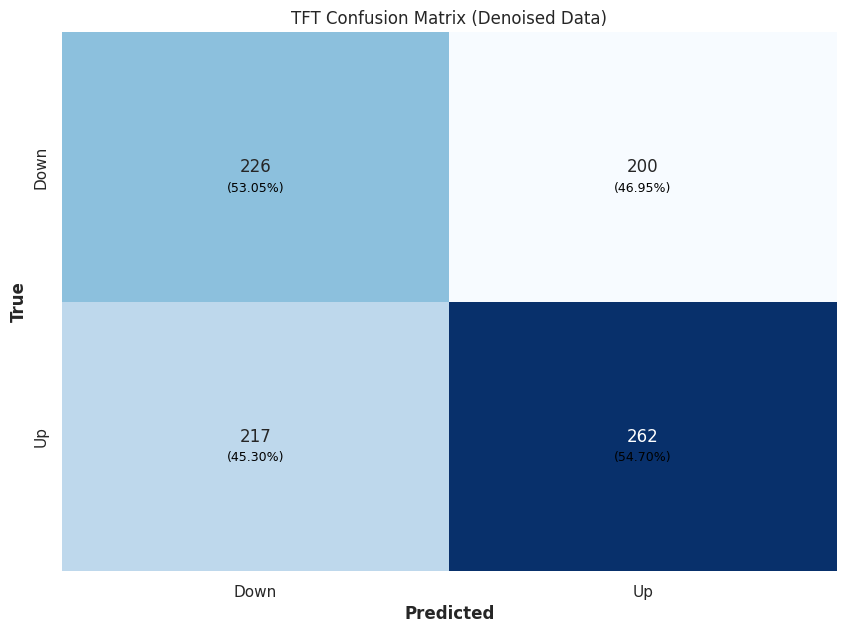

In [49]:
model = get_model_tft()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### TiDE

TimeSeries Dense Encoder Model

**References**:
- Paper (2024): https://doi.org/10.48550/arXiv.2304.08424
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tide_model.py
- Darts documentation: https://unit8co.github.io/darts/examples/18-TiDE-examples.html

**+RIN**

Reversible Instance Normalization for Accurate Time-Series Forecasting against Distribution Shift

- Paper: https://openreview.net/forum?id=cGDAkQo1C0p

**Not denoised**

Price Prediction Metrics:

TiDE (Original) | MAE: 38.08
TiDE (Original) | MSE: 2576.77
TiDE (Original) | RMSE: 50.76
TiDE (Original) | RMSSE: 1.14
TiDE (Original) | MAPE: 0.95%
TiDE (Original) | MASE: 1.14
TiDE (Original) | R2: 0.99


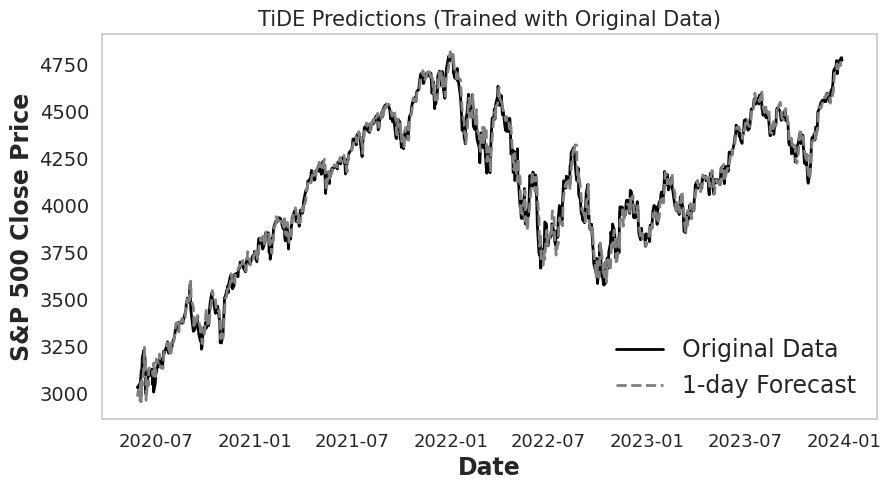

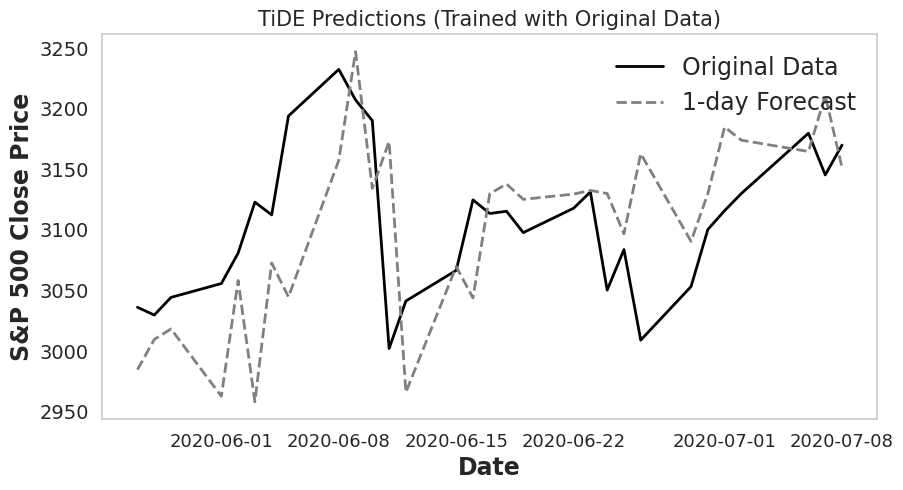


Directional Movement Metrics:

TiDE (Original) | Train Accuracy: 55.70%
TiDE (Original) | Validation Accuracy: 52.24%
TiDE (Original) | Test Accuracy: 49.28%
TiDE (Original) | Recall: 52.19%
TiDE (Original) | Precision (Rise): 52.08%
TiDE (Original) | Precision (Fall): 46.12%
TiDE (Original) | F1 Score: 52.14%


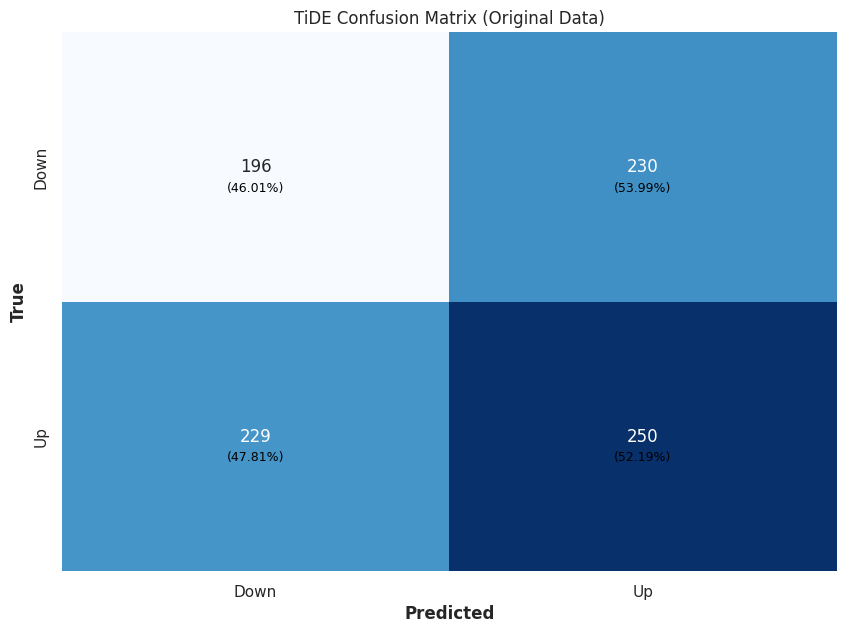

In [50]:
model = get_model_tide()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

**Denoised**

Price Prediction Metrics:

TiDE (Denoised) | MAE: 27.43
TiDE (Denoised) | MSE: 1326.16
TiDE (Denoised) | RMSE: 36.42
TiDE (Denoised) | RMSSE: 0.82
TiDE (Denoised) | MAPE: 0.69%
TiDE (Denoised) | MASE: 0.82
TiDE (Denoised) | R2: 0.99


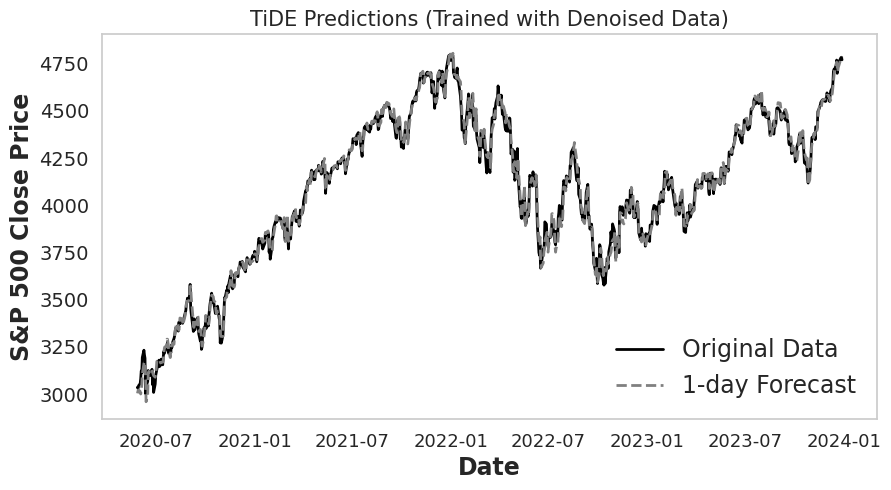

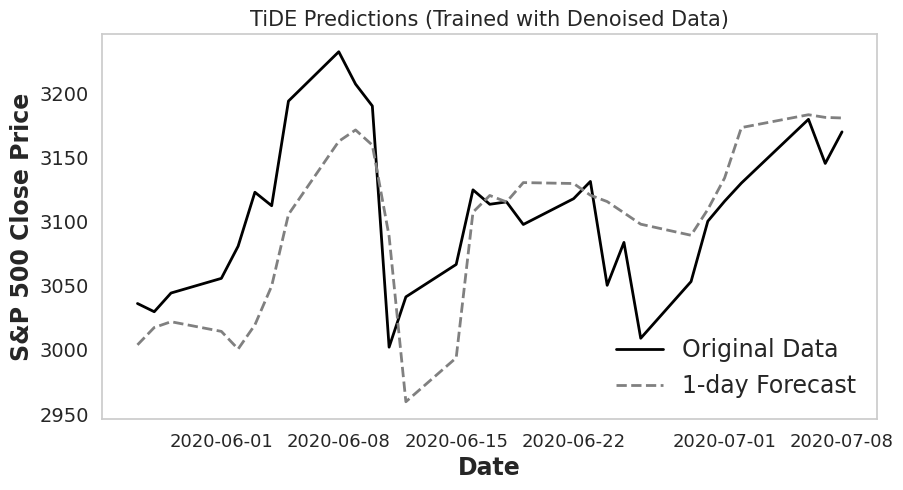


Directional Movement Metrics:

TiDE (Denoised) | Train Accuracy: 68.56%
TiDE (Denoised) | Validation Accuracy: 65.17%
TiDE (Denoised) | Test Accuracy: 67.18%
TiDE (Denoised) | Recall: 72.44%
TiDE (Denoised) | Precision (Rise): 67.77%
TiDE (Denoised) | Precision (Fall): 66.41%
TiDE (Denoised) | F1 Score: 70.03%


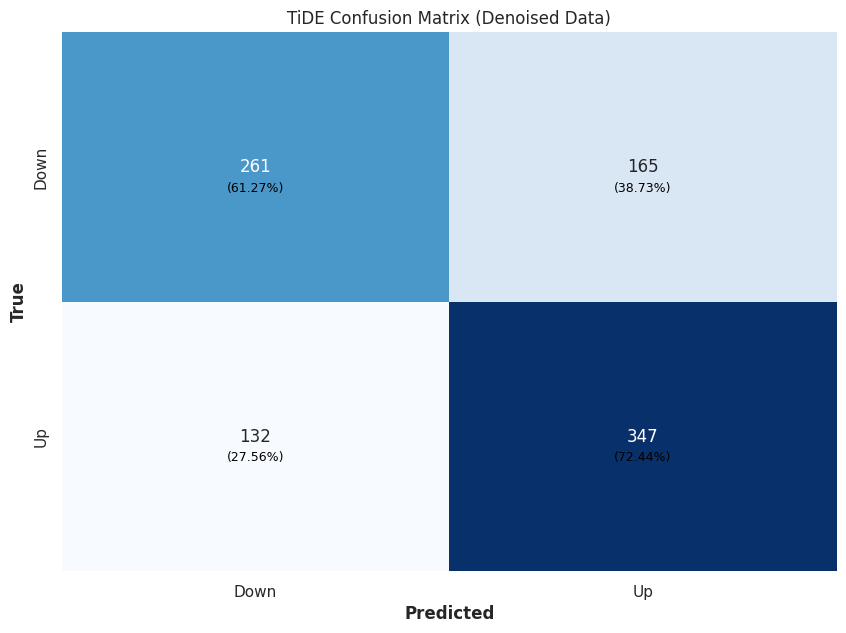

In [51]:
model = get_model_tide()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### N-HiTS

**Neural Hierarchical Interpolation for Time Series Forecasting**

References:

- Paper (2022): https://doi.org/10.48550/arXiv.2201.12886
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/nhits.py
- Darts documentation: https://unit8co.github.io/darts/examples/18-TiDE-examples.html

**Not denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-HiTS (Original) | MAE: 54.36
N-HiTS (Original) | MSE: 5443.09
N-HiTS (Original) | RMSE: 73.78
N-HiTS (Original) | RMSSE: 1.65
N-HiTS (Original) | MAPE: 1.37%
N-HiTS (Original) | MASE: 1.62
N-HiTS (Original) | R2: 0.97


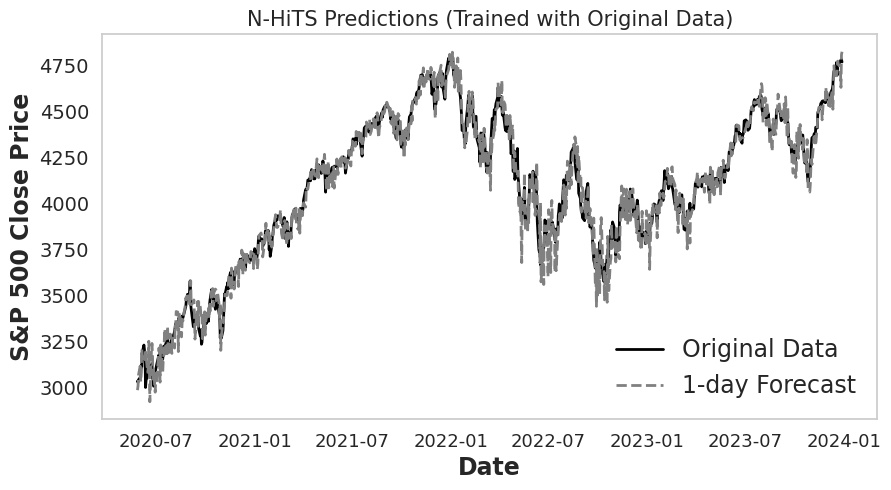

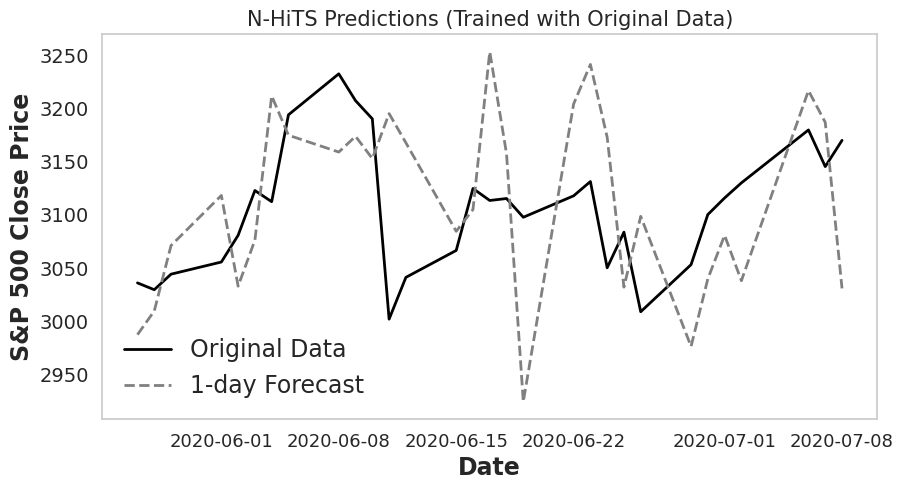


Directional Movement Metrics:

N-HiTS (Original) | Train Accuracy: 48.68%
N-HiTS (Original) | Validation Accuracy: 51.00%
N-HiTS (Original) | Test Accuracy: 51.60%
N-HiTS (Original) | Recall: 52.61%
N-HiTS (Original) | Precision (Rise): 54.43%
N-HiTS (Original) | Precision (Fall): 48.64%
N-HiTS (Original) | F1 Score: 53.50%


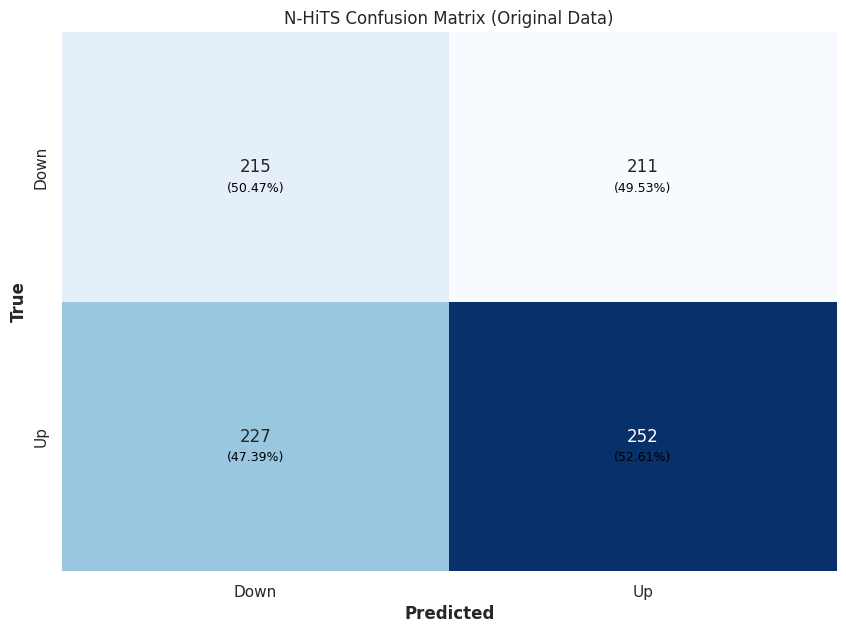

In [52]:
model = get_model_nhits()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

**Denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-HiTS (Denoised) | MAE: 41.86
N-HiTS (Denoised) | MSE: 3173.41
N-HiTS (Denoised) | RMSE: 56.33
N-HiTS (Denoised) | RMSSE: 1.26
N-HiTS (Denoised) | MAPE: 1.05%
N-HiTS (Denoised) | MASE: 1.25
N-HiTS (Denoised) | R2: 0.98


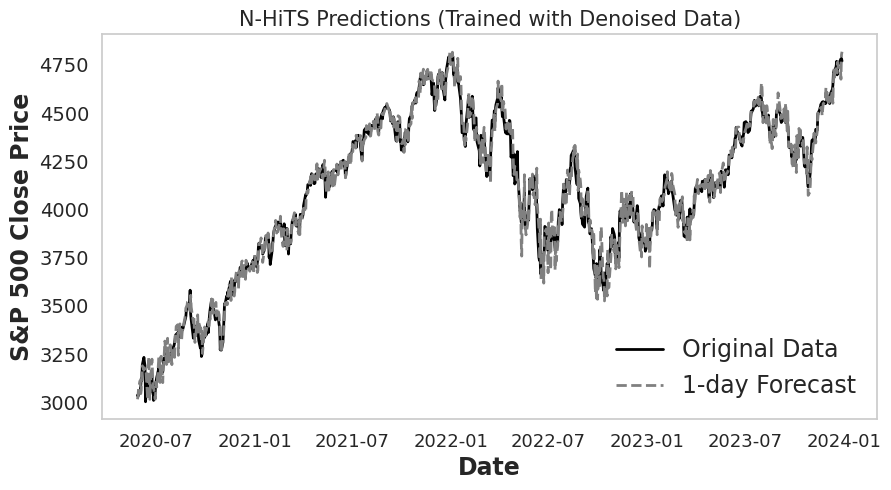

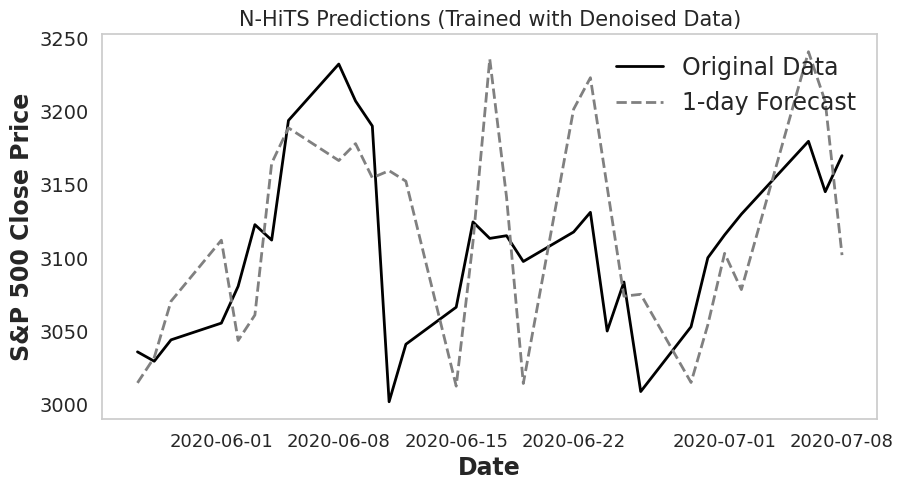


Directional Movement Metrics:

N-HiTS (Denoised) | Train Accuracy: 55.12%
N-HiTS (Denoised) | Validation Accuracy: 55.97%
N-HiTS (Denoised) | Test Accuracy: 57.68%
N-HiTS (Denoised) | Recall: 58.04%
N-HiTS (Denoised) | Precision (Rise): 60.43%
N-HiTS (Denoised) | Precision (Fall): 54.83%
N-HiTS (Denoised) | F1 Score: 59.21%


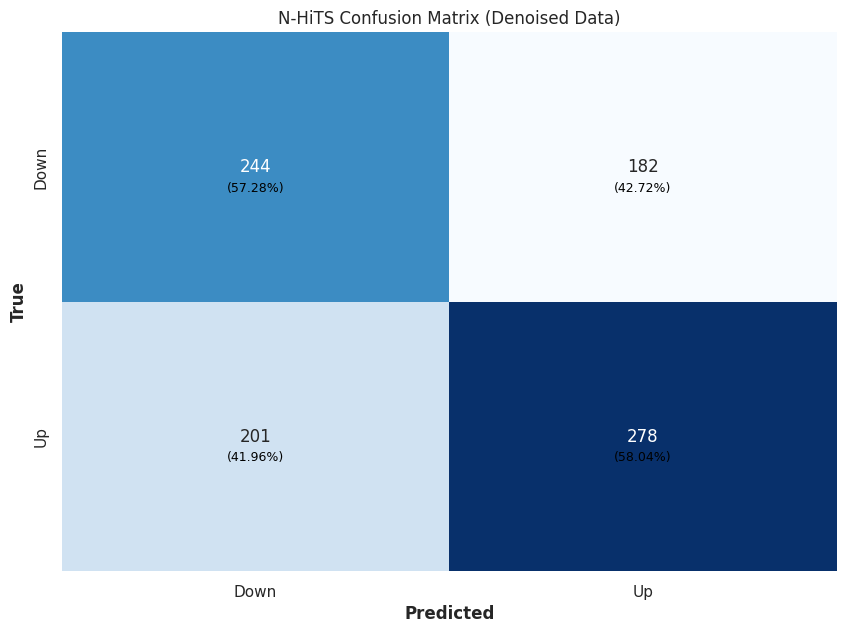

In [53]:
model = get_model_nhits()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### TSMixer

TimeSeries Mixer Model

**References**:
- Paper (2023): https://doi.org/10.48550/arXiv.2303.06053
- Code: https://github.com/ditschuk/pytorch-tsmixer
- Darts documentation: https://unit8co.github.io/darts/examples/21-TSMixer-examples.html

**Not denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TSMixer (Original) | MAE: 111.16
TSMixer (Original) | MSE: 23805.12
TSMixer (Original) | RMSE: 154.29
TSMixer (Original) | RMSSE: 3.46
TSMixer (Original) | MAPE: 2.80%
TSMixer (Original) | MASE: 3.32
TSMixer (Original) | R2: 0.86


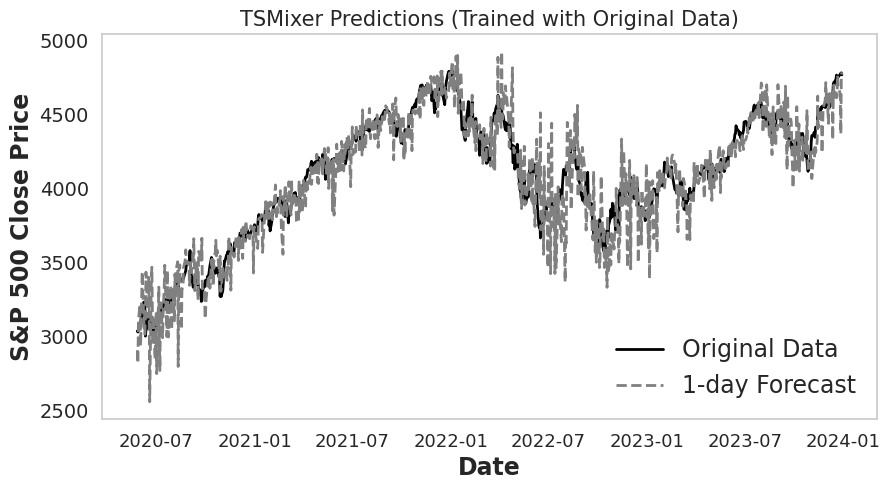

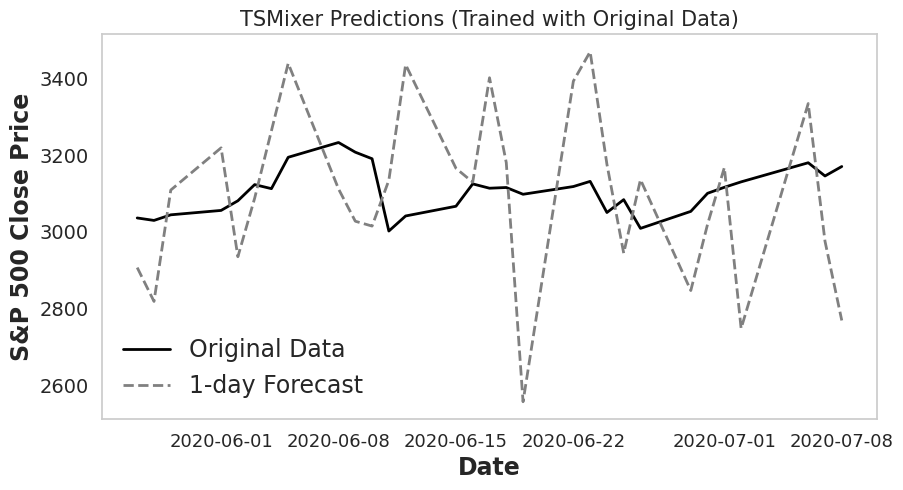


Directional Movement Metrics:

TSMixer (Original) | Train Accuracy: 49.31%
TSMixer (Original) | Validation Accuracy: 46.52%
TSMixer (Original) | Test Accuracy: 50.83%
TSMixer (Original) | Recall: 50.73%
TSMixer (Original) | Precision (Rise): 53.76%
TSMixer (Original) | Precision (Fall): 47.90%
TSMixer (Original) | F1 Score: 52.20%


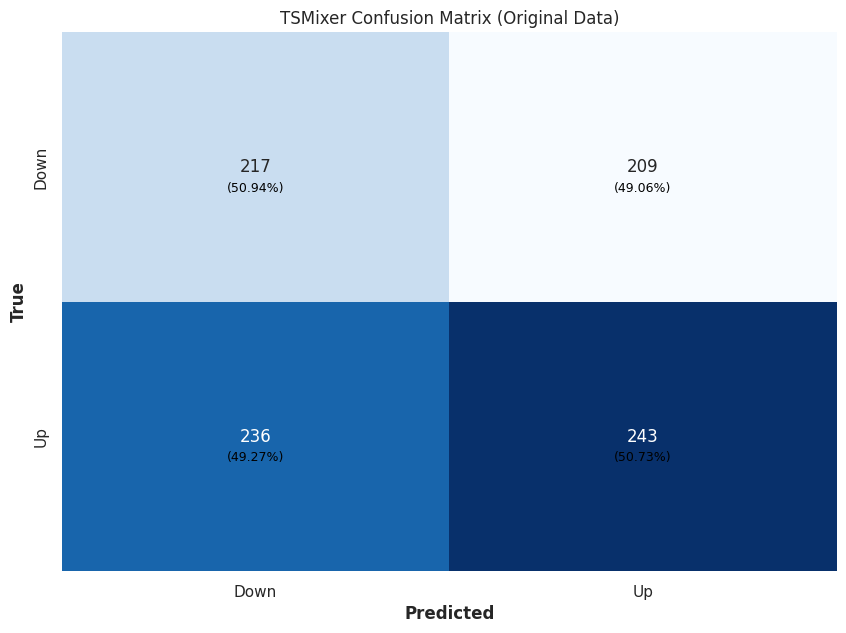

In [54]:
model = get_model_tsm()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

**Denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TSMixer (Denoised) | MAE: 103.06
TSMixer (Denoised) | MSE: 21182.30
TSMixer (Denoised) | RMSE: 145.54
TSMixer (Denoised) | RMSSE: 3.26
TSMixer (Denoised) | MAPE: 2.60%
TSMixer (Denoised) | MASE: 3.08
TSMixer (Denoised) | R2: 0.88


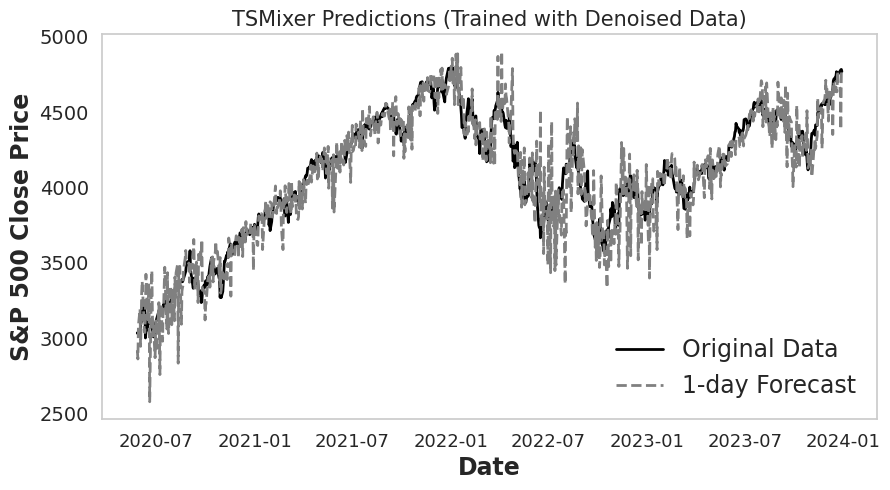

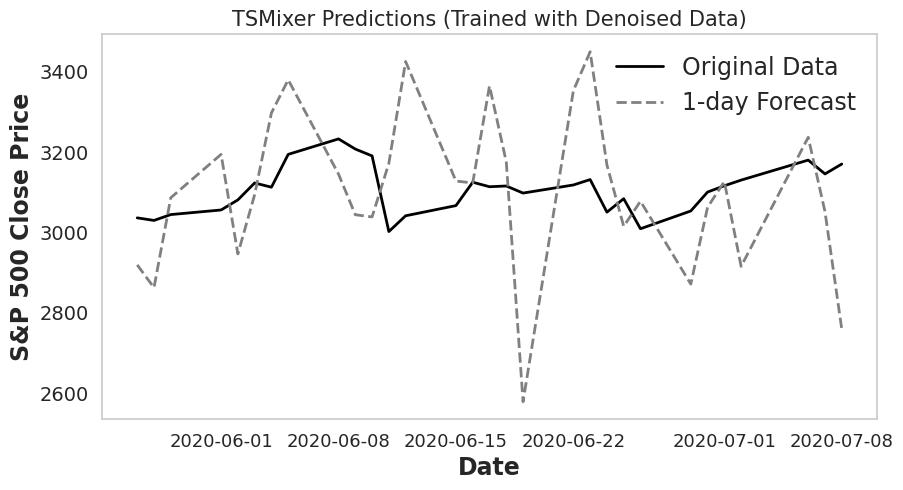


Directional Movement Metrics:

TSMixer (Denoised) | Train Accuracy: 49.67%
TSMixer (Denoised) | Validation Accuracy: 49.25%
TSMixer (Denoised) | Test Accuracy: 50.50%
TSMixer (Denoised) | Recall: 50.52%
TSMixer (Denoised) | Precision (Rise): 53.42%
TSMixer (Denoised) | Precision (Fall): 47.57%
TSMixer (Denoised) | F1 Score: 51.93%


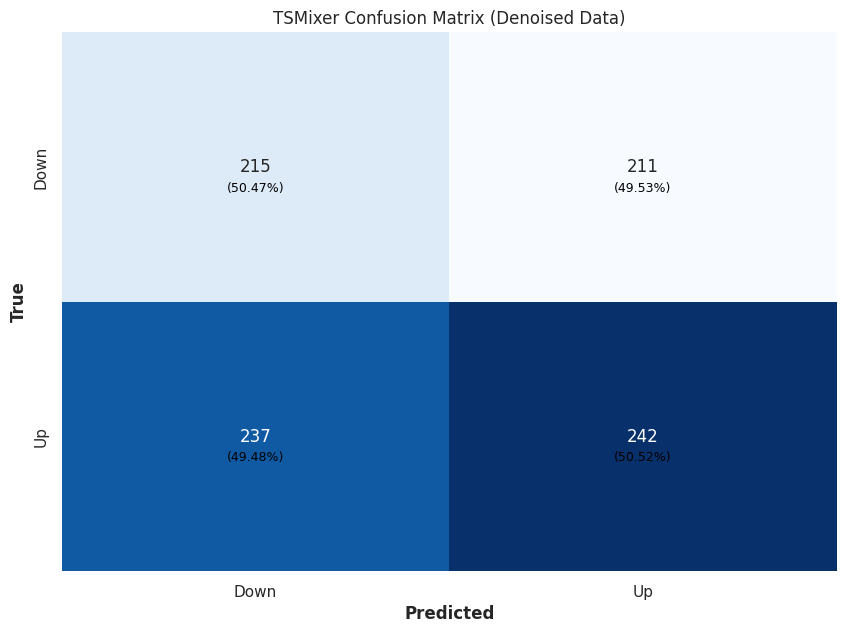

In [55]:
model = get_model_tsm()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### New proposed model: xLSTM-TS, a time series-specific implementation

**References:**

- xLSTM Paper (2024): https://doi.org/10.48550/arXiv.2405.04517

- Official code: https://github.com/NX-AI/xlstm

- Parameters for time series: https://github.com/smvorwerk/xlstm-cuda

#### Configuration

In [56]:
from ml.models.xlstm_ts.xlstm_ts_model import *
from ml.models.xlstm_ts.logic import *

In [57]:
plot_architecture_xlstm()

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=2', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_H

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py310_cu121/slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


#### Training and evaluation

In [58]:
model_name = 'xLSTM-TS'

**Not denoised**

Epoch [1/200], Loss: 0.00091304, Validation Loss: 0.00012387
Epoch [2/200], Loss: 0.00176997, Validation Loss: 0.00031005
Epoch [3/200], Loss: 0.00082824, Validation Loss: 0.00011379
Epoch [4/200], Loss: 0.00163577, Validation Loss: 0.00037995
Epoch [5/200], Loss: 0.00064226, Validation Loss: 0.00010185
Epoch [6/200], Loss: 0.00047536, Validation Loss: 0.00008076
Epoch [7/200], Loss: 0.00040942, Validation Loss: 0.00008597
Epoch [8/200], Loss: 0.00038582, Validation Loss: 0.00009663
Epoch [9/200], Loss: 0.00026665, Validation Loss: 0.00006610
Epoch [10/200], Loss: 0.00020487, Validation Loss: 0.00005994
Epoch [11/200], Loss: 0.00049430, Validation Loss: 0.00019380
Epoch [12/200], Loss: 0.00008404, Validation Loss: 0.00004528
Epoch [13/200], Loss: 0.00003631, Validation Loss: 0.00005522
Epoch [14/200], Loss: 0.00008194, Validation Loss: 0.00004514
Epoch [15/200], Loss: 0.00007806, Validation Loss: 0.00005185
Epoch [16/200], Loss: 0.00017542, Validation Loss: 0.00007257
Epoch [17/200], L

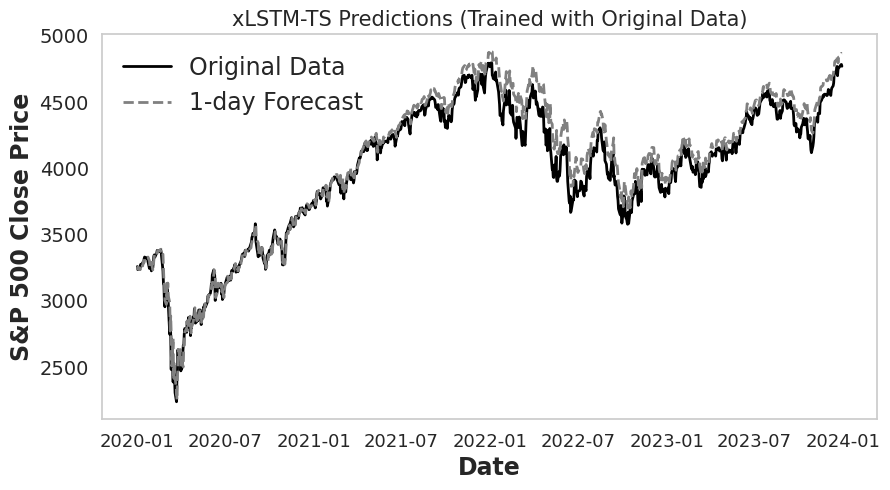

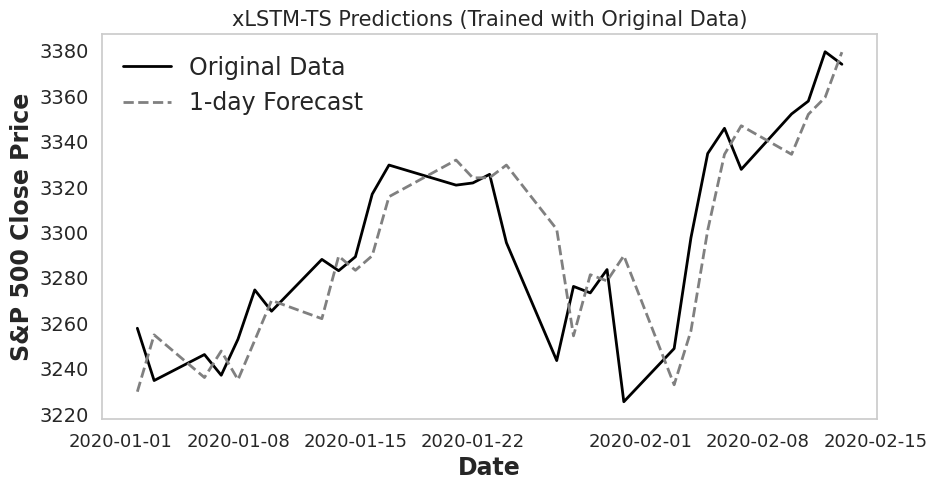

xLSTM-TS (Original) | Train Accuracy: 47.29%
xLSTM-TS (Original) | Validation Accuracy: 52.59%
xLSTM-TS (Original) | Test Accuracy: 47.26%
xLSTM-TS (Original) | Recall: 51.32%
xLSTM-TS (Original) | Precision (Rise): 50.18%
xLSTM-TS (Original) | Precision (Fall): 43.82%
xLSTM-TS (Original) | F1 Score: 50.74%


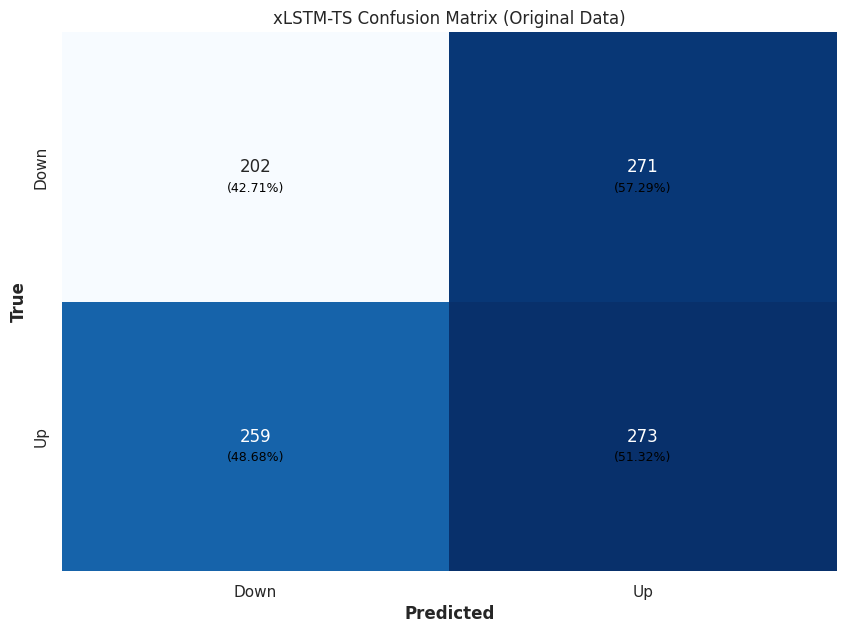

In [59]:
results_df, metrics = run_xlstm_ts(train_X, train_y, val_X, val_y, test_X, test_y, scaler, STOCK, 'Original', test_dates)

In [60]:
metrics_accumulator[model_name] = metrics

**Denoised**

Epoch [1/200], Loss: 0.00236001, Validation Loss: 0.00038970
Epoch [2/200], Loss: 0.00127191, Validation Loss: 0.00022472
Epoch [3/200], Loss: 0.00097913, Validation Loss: 0.00015869
Epoch [4/200], Loss: 0.00128739, Validation Loss: 0.00021558
Epoch [5/200], Loss: 0.00091719, Validation Loss: 0.00013399
Epoch [6/200], Loss: 0.00111173, Validation Loss: 0.00018974
Epoch [7/200], Loss: 0.00046788, Validation Loss: 0.00007298
Epoch [8/200], Loss: 0.00067669, Validation Loss: 0.00008916
Epoch [9/200], Loss: 0.00046326, Validation Loss: 0.00007537
Epoch [10/200], Loss: 0.00060873, Validation Loss: 0.00008264
Epoch [11/200], Loss: 0.00111581, Validation Loss: 0.00020931
Epoch [12/200], Loss: 0.00056078, Validation Loss: 0.00007421
Epoch [13/200], Loss: 0.00046092, Validation Loss: 0.00007393
Epoch [14/200], Loss: 0.00034369, Validation Loss: 0.00008476
Epoch [15/200], Loss: 0.00013654, Validation Loss: 0.00008008
Epoch [16/200], Loss: 0.00002152, Validation Loss: 0.00020559
Epoch [17/200], L

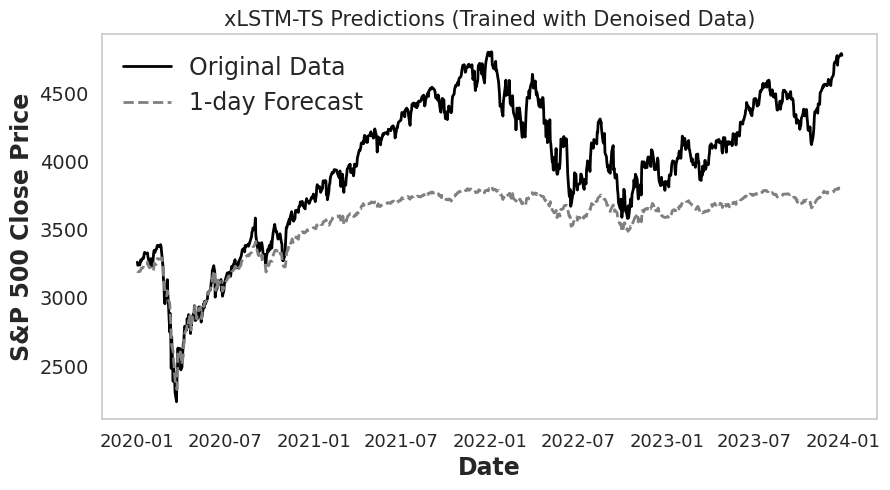

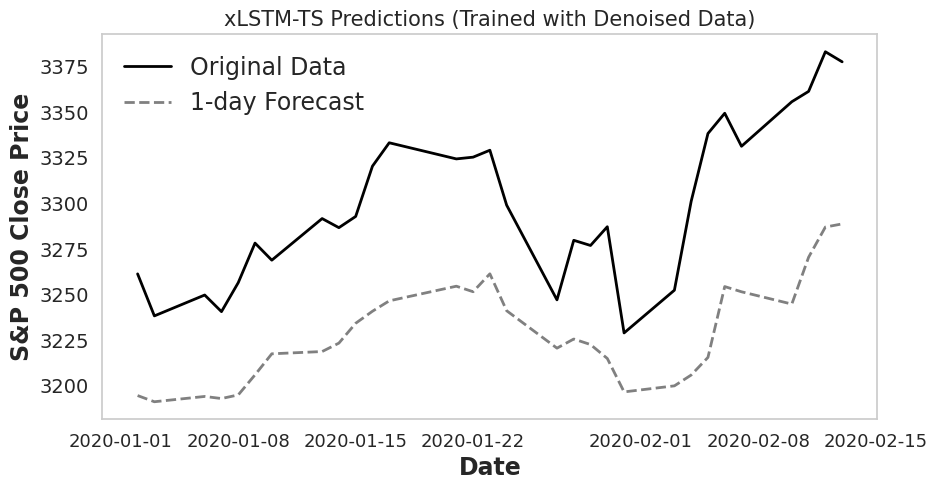

xLSTM-TS (Denoised) | Train Accuracy: 67.51%
xLSTM-TS (Denoised) | Validation Accuracy: 64.94%
xLSTM-TS (Denoised) | Test Accuracy: 64.68%
xLSTM-TS (Denoised) | Recall: 69.74%
xLSTM-TS (Denoised) | Precision (Rise): 65.66%
xLSTM-TS (Denoised) | Precision (Fall): 63.41%
xLSTM-TS (Denoised) | F1 Score: 67.64%


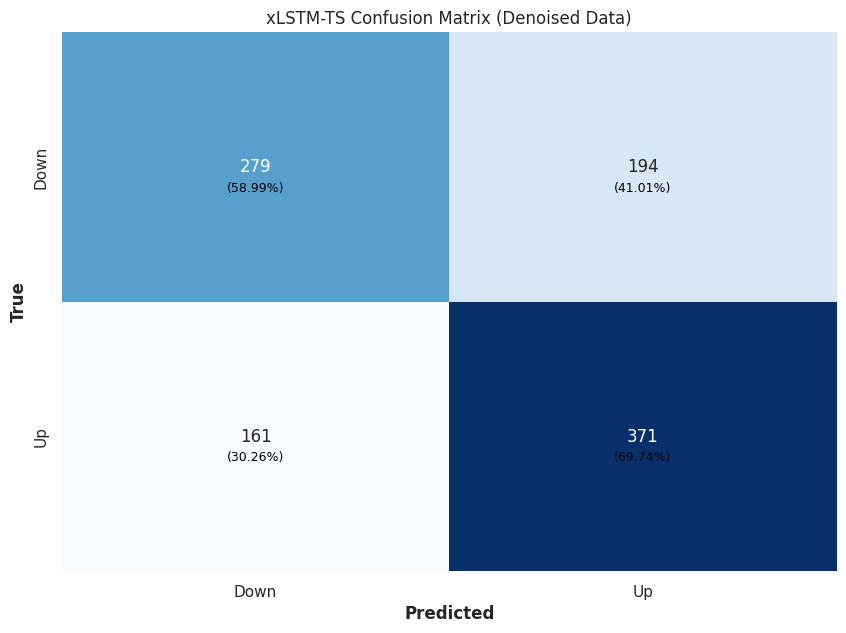

In [61]:
results_denoised_df, metrics_denoised = run_xlstm_ts(train_X_denoised, train_y_denoised, val_X_denoised, val_y_denoised, test_X_denoised, test_y, scaler_denoised, STOCK, 'Denoised', test_dates, train_y, val_y, test_y)

In [62]:
metrics_accumulator_denoised[model_name] = metrics_denoised

## Results

In [63]:
from ml.results.results import *

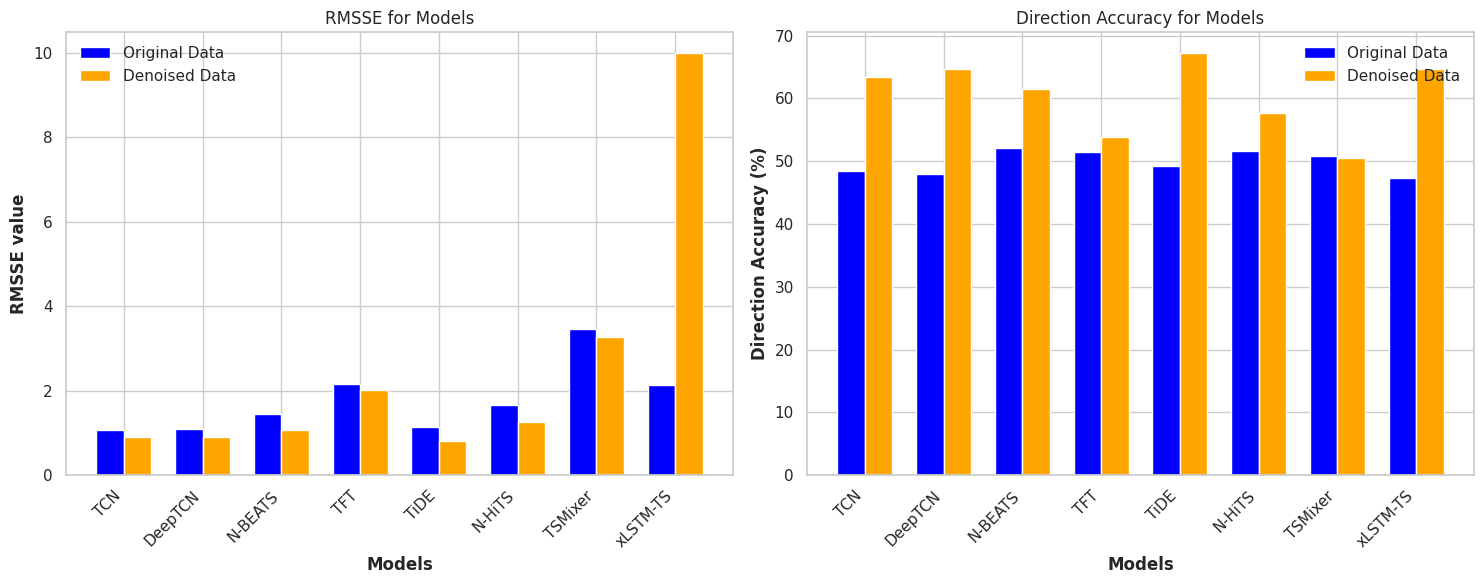

In [64]:
final_results = display_metrics(metrics_accumulator, metrics_accumulator_denoised)

In [65]:
original_data = show_results(final_results, 'Original')
denoised_data = show_results(final_results, 'Denoised')

In [66]:
original_data

MAE       MSE    RMSE  RMSSE   MAPE  MASE    R2 Test Accuracy  \
TCN        35.75   2251.25   47.45   1.06  0.89%  1.07  0.99        48.51%   
DeepTCN    39.27   2389.67   48.88   1.10  0.98%  1.17  0.99        47.96%   
N-BEATS    48.06   4116.32   64.16   1.44  1.21%  1.44  0.98        52.15%   
TFT        67.78   9255.08   96.20   2.16  1.71%  2.02  0.95        51.49%   
TiDE       38.08   2576.77   50.76   1.14  0.95%  1.14  0.99        49.28%   
N-HiTS     54.36   5443.09   73.78   1.65  1.37%  1.62  0.97        51.60%   
TSMixer   111.16  23805.12  154.29   3.46  2.80%  3.32  0.86        50.83%   
xLSTM-TS   82.93  11298.32  106.29   2.13  2.08%  2.31  0.96        47.26%   

          Recall Precision (Rise) Precision (Fall) F1 Score  \
TCN       52.61%           51.32%           45.17%   51.96%   
DeepTCN   51.77%           50.82%           44.60%   51.29%   
N-BEATS   53.24%           54.96%           49.21%   54.08%   
TFT       53.24%           54.26%           48.51%   53.74%   
TiDE      52.19%           52.08%           46.12%   52.14%   
N-HiTS    52.61%           54.43%           48.64%   53.50%   
TSMixer   50.73%           53.76%           47.90%   52.20%   
xLSTM-TS  51.32%           50.18%           43.82%   50.74%   

         Validation Accuracy Train Accuracy  
TCN                   50.75%         47.91%  
DeepTCN               52.24%         47.12%  
N-BEATS               50.25%         53.72%  
TFT                   49.00%         48.57%  
TiDE                  52.24%         55.70%  
N-HiTS                51.00%         48.68%  
TSMixer               46.52%         49.31%  
xLSTM-TS              52.59%         47.29%

In [67]:
denoised_data

MAE        MSE    RMSE  RMSSE   MAPE   MASE    R2 Test Accuracy  \
TCN        30.61    1622.53   40.28   0.90  0.76%   0.91  0.99        63.43%   
DeepTCN    32.46    1638.08   40.47   0.91  0.81%   0.97  0.99        64.64%   
N-BEATS    35.25    2277.16   47.72   1.07  0.88%   1.05  0.99        61.44%   
TFT        62.68    8001.78   89.45   2.00  1.58%   1.87  0.95        53.92%   
TiDE       27.43    1326.16   36.42   0.82  0.69%   0.82  0.99        67.18%   
N-HiTS     41.86    3173.41   56.33   1.26  1.05%   1.25  0.98        57.68%   
TSMixer   103.06   21182.30  145.54   3.26  2.60%   3.08  0.88        50.50%   
xLSTM-TS  419.20  249375.34  499.37   9.98  9.84%  11.67  0.09        64.68%   

          Recall Precision (Rise) Precision (Fall) F1 Score  \
TCN       70.77%           63.96%           62.67%   67.20%   
DeepTCN   72.23%           64.92%           64.25%   68.38%   
N-BEATS   65.14%           63.16%           59.37%   64.13%   
TFT       54.70%           56.71%           51.02%   55.69%   
TiDE      72.44%           67.77%           66.41%   70.03%   
N-HiTS    58.04%           60.43%           54.83%   59.21%   
TSMixer   50.52%           53.42%           47.57%   51.93%   
xLSTM-TS  69.74%           65.66%           63.41%   67.64%   

         Validation Accuracy Train Accuracy  
TCN                   63.18%         64.20%  
DeepTCN               65.92%         64.72%  
N-BEATS               59.95%         61.89%  
TFT                   50.50%         51.52%  
TiDE                  65.17%         68.56%  
N-HiTS                55.97%         55.12%  
TSMixer               49.25%         49.67%  
xLSTM-TS              64.94%         67.51%

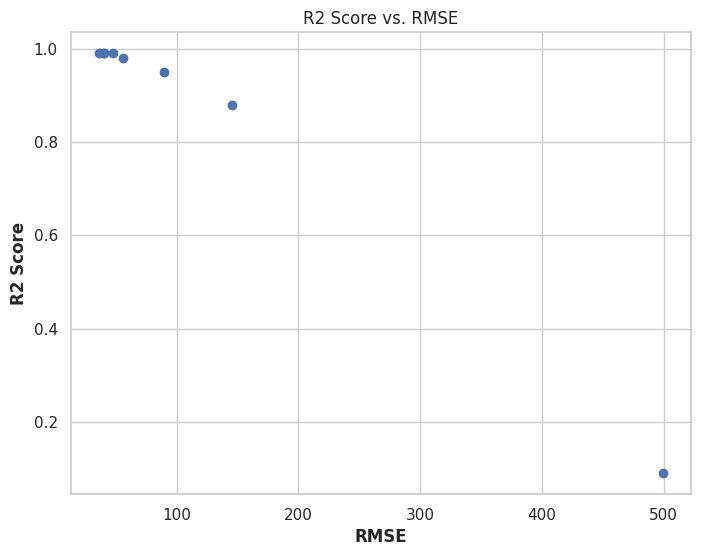

In [71]:
# @title R2 Score vs. RMSE

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(denoised_data['RMSE'], denoised_data['R2'])
plt.xlabel('RMSE')
plt.ylabel('R2 Score')
_ = plt.title('R2 Score vs. RMSE')

## Export

In [68]:
results_df.head(10)

Date        Close  Predicted Value  True Label  Predicted Label
0 2020-01-02  3257.850342      3229.933838           0                1
1 2020-01-03  3234.850098      3254.932129           1                0
2 2020-01-06  3246.280029      3236.172119           0                1
3 2020-01-07  3237.179932      3247.831787           1                0
4 2020-01-08  3253.050049      3235.218506           1                1
5 2020-01-09  3274.699951      3252.556396           0                1
6 2020-01-10  3265.350098      3270.097656           1                0
7 2020-01-13  3288.129883      3262.055176           0                1
8 2020-01-14  3283.149902      3289.575684           1                0
9 2020-01-15  3289.290039      3283.333008           1                1

In [69]:
results_denoised_df.head(10)

Date        Close  Predicted Value  True Label  Predicted Label
0 2020-01-02  3261.342285      3194.627686           0                0
1 2020-01-03  3238.307861      3191.239746           1                1
2 2020-01-06  3249.754883      3194.144775           0                0
3 2020-01-07  3240.641113      3193.001465           1                1
4 2020-01-08  3256.534912      3194.988525           1                1
5 2020-01-09  3278.216797      3206.000000           0                1
6 2020-01-10  3268.853027      3217.525879           1                1
7 2020-01-13  3291.666748      3218.767822           0                1
8 2020-01-14  3286.679443      3223.384277           1                1
9 2020-01-15  3292.828369      3234.260986           1                1

from matplotlib import pyplot as plt
_df_0['Close'].plot(kind='hist', bins=20, title='Close')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Predicted Value'].plot(kind='hist', bins=20, title='Predicted Value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['True Label'].plot(kind='hist', bins=20, title='True Label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Predicted Label'].plot(kind='hist', bins=20, title='Predicted Label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Close', y='Predicted Value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Predicted Value', y='True Label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='True Label', y='Predicted Label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Close']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Close')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Predicted Value']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Predicted Value')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['True Label']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('True Label')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Predicted Label']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Predicted Label')

from matplotlib import pyplot as plt
_df_11['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['Predicted Value'].plot(kind='line', figsize=(8, 4), title='Predicted Value')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['True Label'].plot(kind='line', figsize=(8, 4), title='True Label')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Predicted Label'].plot(kind='line', figsize=(8, 4), title='Predicted Label')
plt.gca().spines[['top', 'right']].set_visible(False)

In [70]:
# -- Save predictions as CSV --

%cd ..

save_results(results_df, results_denoised_df, FILE_NAME)

# -- Save the xLSTM-TS model --

# Rename the file
!mv xlstm-ts/xlstm_ts_model.pth xlstm_model_{FILE_NAME}.pth

# Download if necessary

/content
